# Week HW 18

# Import


In [4134]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math
import joblib

params = {
    "WLSACCESSID": "6b17a71b-0eef-4689-af84-ccf48839fa6c",
    "WLSSECRET": "c045855e-1648-4bba-8fa2-11c3b1fc201e",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [4135]:
#####################

salvage_value = 0
cost = 70
price = 100
holding_cost = 20

model_prefix = f"med_with_holding_cost_{holding_cost}"

#####################

data_size = 100
train_size = 0.5
testing_size = 0.5
k_fold = 2

T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 8000
MIPGAP = 0.01
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [4136]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4137]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [4138]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

In [4139]:
show_models("linear_constraint_med_with_holding_cost")

In [4140]:
show_models("med_with_holding_cost")

Contents of models/med_with_holding_cost_20_s10_100_202502051826.pkl:
{'alpha': array([-0.18655502,  0.22898727,  1.5656777 ,  0.1436452 ,  1.8331839 ]), 'f_values': array([-9.06127735e-01,  3.97356116e-01,  7.71619981e-01,  3.85640256e-01,
        4.00000000e+00,  4.42447867e-01,  1.64740031e-03,  1.21967622e+00,
        2.99351287e+00,  2.35267270e+00,  4.14050824e+00, -1.86870621e-01,
       -2.05009355e-01,  2.00000000e+00,  3.50890831e+00, -5.06547671e-03,
        1.11086777e+00,  1.12008597e+00, -5.48831610e-01,  1.79362894e+00,
        3.37608497e+00,  2.61431438e+00,  2.16193331e+00,  3.56532331e+00,
        3.31860037e+00,  1.51971400e+00,  1.96992981e+00,  1.65657376e+00,
        1.75716758e-01,  4.00000000e+00,  3.99786984e+00,  1.28020320e+00,
        3.57972094e+00,  1.74428210e+00,  1.69422269e+00,  3.44335823e+00,
        3.96992833e+00,  2.31123368e+00,  1.68852497e+00,  3.97062987e+00,
        1.54541764e+00,  6.62577881e-01,  3.19514112e+00, -1.51182158e+00,
        3

## Visualization 

In [4141]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [4142]:
# def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
#     """
#     繪製多個策略相對於基準的平均利潤偏差。

#     :param baseline_profit: 基準利潤值
#     :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
#     """
#     print(f"Baseline is: {baseline_profit}")
#     for i, profit in enumerate(max_profits):
#         print(f"S{i+1}'s profit: {profit}")

#     # 計算相對值
#     ratios = {}
#     for idx, max_profit in enumerate(max_profits, start=1):
#         if max_profit is not None and max_profit != -1:
#             ratio = max_profit / baseline_profit
#             ratios[f"S{idx}"] = ratio - 1  # 相對偏差

#     # 設置 y 軸範圍
#     if ratios:
#         y_min = min(ratios.values()) - 0.1
#         y_max = max(ratios.values()) + 0.1
#     else:
#         y_min, y_max = -0.1, 0.1

#     # 創建圖表顯示結果
#     plt.figure(figsize=(12, 8))

#     if ratios:
#         bars = plt.bar(
#             ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
#         )

#         # 在每個柱狀圖上標出數值
#         for bar in bars:
#             yval = bar.get_height()
#             plt.text(
#                 bar.get_x() + bar.get_width() / 2,
#                 yval,
#                 f"{yval:.4f}",
#                 ha="center",
#                 va="bottom",
#             )

#     # 添加基準線，表示基準值（No Opt）
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # 設置圖表標題和軸標籤
#     plt.title("Relative Avg Profit Deviation from Baseline (1)")
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline (1)")
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_deviation"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [4143]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            if baseline_profit != 0:
                ratio = (max_profit - baseline_profit) / abs(baseline_profit)
                ratios[f"S{idx}"] = ratio
            else:
                # 基準利潤為零時，直接記錄增量
                ratio = max_profit
                ratios[f"S{idx}"] = ratio

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [4144]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            if test_baseline_profit != 0:
                test_ratio = (test_profit - test_baseline_profit) / abs(
                    test_baseline_profit
                )  # Relative deviation
            else:
                test_ratio = test_profit  # Use profit directly if baseline is zero
            test_ratios[f"S{idx}"] = test_ratio

        if train_profit is not None and train_profit != -1:
            if train_baseline_profit != 0:
                train_ratio = (train_profit - train_baseline_profit) / abs(
                    train_baseline_profit
                )  # Relative deviation
            else:
                train_ratio = train_profit  # Use profit directly if baseline is zero
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()


# def plot_relative_profit_comparison(
#     save_type,
#     train_baseline_profit,
#     test_baseline_profit,
#     test_max_profits,
#     train_max_profits,
# ):

#     # Calculate relative deviations from baseline for test and train data
#     test_ratios, train_ratios = {}, {}
#     for idx, (test_profit, train_profit) in enumerate(
#         zip(test_max_profits, train_max_profits), start=1
#     ):
#         if test_profit is not None and test_profit != -1:
#             test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
#             test_ratios[f"S{idx}"] = test_ratio
#         if train_profit is not None and train_profit != -1:
#             train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
#             train_ratios[f"S{idx}"] = train_ratio

#     # Define the range of the y-axis
#     y_min = (
#         min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
#         - 0.1
#     )
#     y_max = (
#         max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
#         + 0.1
#     )

#     # Create bar plot for relative profit deviation comparison
#     plt.figure(figsize=(14, 8))
#     bar_width = 0.35
#     indices = np.arange(len(train_ratios))

#     # Plot bars for train and test ratios, with train on the left for each pair
#     train_bars = plt.bar(
#         indices - bar_width / 2,
#         train_ratios.values(),
#         bar_width,
#         label="Train Data",
#         color="salmon",
#     )
#     test_bars = plt.bar(
#         indices + bar_width / 2,
#         test_ratios.values(),
#         bar_width,
#         label="Test Data",
#         color="skyblue",
#     )

#     # Add baseline line
#     plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

#     # Add labels for each bar
#     for bar in train_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )
#     for bar in test_bars:
#         yval = bar.get_height()
#         plt.text(
#             bar.get_x() + bar.get_width() / 2,
#             yval,
#             f"{yval:.2f}",
#             ha="center",
#             va="bottom",
#         )

#     # Set plot labels and title
#     plt.xlabel("Strategies")
#     plt.ylabel("Deviation from Baseline")
#     plt.title("Relative Profit Deviation Comparison between Train and Test Data")
#     plt.xticks(indices, train_ratios.keys())
#     plt.ylim(y_min, y_max)
#     plt.legend()

#     name = "plot_relative_profit_comparison"

#     os.makedirs("plots", exist_ok=True)
#     save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

#     plt.savefig(save_path, format="png", bbox_inches="tight")
#     print(f"Plot saved as {save_path}")

#     # Show plot
#     plt.show()
#     plt.close()

In [4145]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [4146]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [4147]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [4148]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [4149]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [4150]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [4151]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(10, 15, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
        "X3": np.random.uniform(600, 800, data_size),
        # "X3": np.random.uniform(50, 150, data_size),
        # "X3": np.random.uniform(180, 200, data_size),
        # "X3": np.random.uniform(50, 60, data_size),
        "X4": np.random.uniform(5, 15, data_size),
    }
)

full_df

X1         X2          X3         X4
0   12.744068 -16.443669  662.359176  14.065555
1   13.575947 -24.599841  739.268698  12.740473
2   13.013817 -15.296120  675.550368   8.331452
3   12.724416 -10.756229  635.920736   5.811014
4   12.118274 -25.024937  604.935746   9.072412
..        ...        ...         ...        ...
95  10.915957 -20.190824  644.863406  14.589827
96  12.932565 -25.451707  619.568897   8.553688
97  10.100538 -24.912870  772.438303   8.567069
98  14.144700 -28.839417  794.583898   5.163285
99  10.023477 -21.311667  792.166932   6.852323

[100 rows x 4 columns]

In [4152]:
features_num = full_df.shape[1]
features_num

4

### Split training and testing data


In [4153]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (50, 4), Test size: (50, 4)
Train (normalized):
         X1        X2        X3        X4
0  0.570745 -1.070472 -1.500939 -0.262628
1 -0.919142 -1.565333 -0.947965  1.638421
2  0.153009  0.575725 -0.877980  1.460411
3 -1.713904  0.196333 -1.249577  1.003836
4  0.058029  0.513662  1.385866 -0.764386
Test (normalized):
         X1        X2        X3        X4
0 -1.275151 -1.741127  0.460194  0.663123
1  0.062959  0.075563  1.508605  1.135347
2  0.343038  0.777563 -0.643052 -0.587176
3 -1.211904  1.174411 -1.691421  0.656378
4 -1.642055 -1.020939  1.392806 -1.203534

Fold 2:
Train size: (50, 4), Test size: (50, 4)
Train (normalized):
         X1        X2        X3        X4
0 -1.428676  1.189848 -1.121977 -1.291055
1 -1.085011  1.030549 -1.281212  0.884910
2 -1.231322 -0.508037 -0.946630 -0.547808
3 -0.193093 -1.143207 -1.473502 -0.051902
4 -0.048071 -0.568513  1.594485 -0.101675
Test (normalized):
         X1        X2        X3        X4
0 -0.552354 -1.448126 -0.59

## Data2: demand_df


### mu of each time(t)


In [4154]:
# 設定 b0, b1, b2

# b0 = 0
# b1 = 1
# b2 = 2
# b3 = -1
# b4 = 2
# bt = 0

b0 = 0
b1 = 0
b2 = 0
b3 = 1
b4 = 0
bt = 0

# b0 = 0
# b1 = 1
# b2 = 1


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix

In [4155]:
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[:3]}")

mu_matrix shape: (100, 10)
mu_matrix[0]: 
[[662.3591764  662.3591764  662.3591764  662.3591764  662.3591764
  662.3591764  662.3591764  662.3591764  662.3591764  662.3591764 ]
 [739.26869776 739.26869776 739.26869776 739.26869776 739.26869776
  739.26869776 739.26869776 739.26869776 739.26869776 739.26869776]
 [675.55036786 675.55036786 675.55036786 675.55036786 675.55036786
  675.55036786 675.55036786 675.55036786 675.55036786 675.55036786]]


### sigma matrix


In [4156]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量
print(f"X.shape: {X.shape}")

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

X.shape: (100, 4)
coefficients.shape: (4, 10)
coefficients: [[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [4157]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
# print(f"sigma_matrix.shape: {sigma_matrix.shape}")
# print(f"sigma_matrix: {sigma_matrix}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到 [2, 10] 的範圍
# shape: (data_size, T)
# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
# sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 50 + sigma_matrix * 50
# sigma_matrix = 0 + sigma_matrix * 10
sigma_matrix = 0 + sigma_matrix * 200

# sigma_matrix = 0 + sigma_matrix * 50
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3


# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

Value range: (np.float64(1.107550458685947e-263), np.float64(1.0))
New Value range: (np.float64(2.215100917371894e-261), np.float64(200.0))


((100, 10),
 array([[2.00000000e+002, 1.01789769e-020, 2.00000000e+002,
         2.13062613e-218, 2.00000000e+002, 7.68057922e-196,
         2.00000000e+002, 2.00000000e+002, 1.22790574e-051,
         5.76498243e-139],
        [2.00000000e+002, 1.19423177e-023, 2.00000000e+002,
         2.32169597e-240, 2.00000000e+002, 1.92859346e-216,
         2.00000000e+002, 2.00000000e+002, 2.97550459e-060,
         1.03334812e-157],
        [2.00000000e+002, 7.52736535e-021, 2.00000000e+002,
         8.05470209e-221, 2.00000000e+002, 5.59612979e-201,
         2.00000000e+002, 2.00000000e+002, 3.52625914e-053,
         2.03370171e-140],
        [2.00000000e+002, 3.47600311e-019, 2.00000000e+002,
         2.67232494e-208, 2.00000000e+002, 7.99273308e-191,
         2.00000000e+002, 2.00000000e+002, 3.75951201e-049,
         3.42211091e-130],
        [2.00000000e+002, 3.59876053e-019, 2.00000000e+002,
         4.94077585e-194, 2.00000000e+002, 6.27847754e-175,
         2.00000000e+002, 2.00000000e+00

### corr matrix


In [4158]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [4159]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (100, 10, 10)
cov_matrices: 
[[ 4.00000000e+004  7.21165835e-019  2.22313440e+004  2.50310494e-216
  -1.55109477e+004 -2.48058548e-194 -3.96291208e+003 -1.10377464e+004
  -1.20062480e-049 -2.41260998e-138]
 [ 7.21165835e-019  1.03611570e-040  1.31445473e-018  7.46592871e-239
  -1.08703795e-018 -9.28114199e-217 -7.46324421e-019  1.47045802e-019
   1.37434778e-072 -2.88281276e-160]
 [ 2.22313440e+004  1.31445473e-018  4.00000000e+004  1.10676653e-216
  -1.71396665e+004 -3.63322789e-194 -2.20617283e+004  4.22501841e+002
  -1.01731033e-049 -1.48400701e-137]
 [ 2.50310494e-216  7.46592871e-239  1.10676653e-216  0.00000000e+000
  -1.84817140e-216 -0.00000000e+000  7.08359364e-217 -2.68894204e-216
   2.33206563e-270  0.00000000e+000]
 [-1.55109477e+004 -1.08703795e-018 -1.71396665e+004 -1.84817140e-216
   4.00000000e+004  5.70511953e-194  1.20124136e+004  1.17607875e+004
  -3.77505592e-050 -1.25156119e-137]
 [-2.48058548e-194 -9.28114199e-217 -3.63322789e-194 -0.00000000e+

In [4160]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [4161]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1   demand_t2    demand_t3   demand_t4   demand_t5   demand_t6  \
0   151.884513  662.359175   373.449914  662.359176  603.661572  662.359176   
1   690.757690  739.268698   605.789384  739.268697  663.379598  739.268698   
2   901.800324  675.550366  1189.301217  675.550368  349.369033  675.550368   
3   820.717174  635.920735   640.361016  635.920735  919.186957  635.920736   
4   820.614599  604.935747   876.198929  604.935746  320.722599  604.935746   
..         ...         ...          ...         ...         ...         ...   
95  628.883809  644.863406   772.218017  644.863405  501.149908  644.863406   
96  687.214811  619.568897   548.825431  619.568897  411.763502  619.568897   
97  750.703126  772.438303   908.187430  772.438304  467.789308  772.438303   
98  782.224299  794.583898   672.970492  794.583898  727.783478  794.583898   
99  804.902953  792.166932   752.912471  792.166932  849.410673  792.166932   

     demand_t7    demand_t8   demand_t9  demand_t10  
0   997.022309   731.361181  662.359176  662.359176  
1   855.929187   455.659220  739.268698  739.268698  
2   403.527760   233.749522  675.550368  675.550368  
3   682.179422   549.326221  635.920736  635.920736  
4   567.184541  1019.060190  604.935746  604.935746  
..         ...          ...         ...         ...  
95  415.470159   393.715788  644.863406  644.863406  
96  660.121800   482.167636  619.568897  619.568897  
97  915.073121   592.117469  772.438303  772.438303  
98  869.410518   954.264967  794.583898  794.583898  
99  968.709585   865.391786  792.166932  792.166932  

[100 rows x 10 columns]

### Replace negative values to 0


In [4162]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1   demand_t2    demand_t3   demand_t4   demand_t5   demand_t6  \
0   151.884513  662.359175   373.449914  662.359176  603.661572  662.359176   
1   690.757690  739.268698   605.789384  739.268697  663.379598  739.268698   
2   901.800324  675.550366  1189.301217  675.550368  349.369033  675.550368   
3   820.717174  635.920735   640.361016  635.920735  919.186957  635.920736   
4   820.614599  604.935747   876.198929  604.935746  320.722599  604.935746   
..         ...         ...          ...         ...         ...         ...   
95  628.883809  644.863406   772.218017  644.863405  501.149908  644.863406   
96  687.214811  619.568897   548.825431  619.568897  411.763502  619.568897   
97  750.703126  772.438303   908.187430  772.438304  467.789308  772.438303   
98  782.224299  794.583898   672.970492  794.583898  727.783478  794.583898   
99  804.902953  792.166932   752.912471  792.166932  849.410673  792.166932   

     demand_t7    demand_t8   demand_t9  demand_t10  
0   997.022309   731.361181  662.359176  662.359176  
1   855.929187   455.659220  739.268698  739.268698  
2   403.527760   233.749522  675.550368  675.550368  
3   682.179422   549.326221  635.920736  635.920736  
4   567.184541  1019.060190  604.935746  604.935746  
..         ...          ...         ...         ...  
95  415.470159   393.715788  644.863406  644.863406  
96  660.121800   482.167636  619.568897  619.568897  
97  915.073121   592.117469  772.438303  772.438303  
98  869.410518   954.264967  794.583898  794.583898  
99  968.709585   865.391786  792.166932  792.166932  

[100 rows x 10 columns]

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [4163]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0        6623.591764     6169.175369       395.655661     210.620421   
1        7392.686978     6967.858567       395.655661     100.958055   
2        6755.503679     6455.499693       395.655661     261.095249   
3        6359.207355     6791.374466       395.655661     102.650293   
4        6049.357457     6628.459588       395.655661     184.463133   
..               ...             ...              ...            ...   
95       6448.634058     5935.754709       395.655661     112.481100   
96       6195.688969     5887.937665       395.655661      79.885072   
97       7724.383035     7496.061971       395.655661     126.237276   
98       7945.838978     7979.573243       395.655661      70.984606   
99       7921.669316     8202.162126       395.655661      58.001320   

    std_relative_error  
0            87.852469  
1           291.901035  
2            51.536906  
3           285.440362  
4           114.490372  
..                 ...  
95          251.753015  
96          395.281096  
97          213.422211  
98          457.382343  
99          582.149410  

[100 rows x 5 columns]

### Validate normal distribution


In [4164]:
demand_df

demand_t1   demand_t2    demand_t3   demand_t4   demand_t5   demand_t6  \
0   151.884513  662.359175   373.449914  662.359176  603.661572  662.359176   
1   690.757690  739.268698   605.789384  739.268697  663.379598  739.268698   
2   901.800324  675.550366  1189.301217  675.550368  349.369033  675.550368   
3   820.717174  635.920735   640.361016  635.920735  919.186957  635.920736   
4   820.614599  604.935747   876.198929  604.935746  320.722599  604.935746   
..         ...         ...          ...         ...         ...         ...   
95  628.883809  644.863406   772.218017  644.863405  501.149908  644.863406   
96  687.214811  619.568897   548.825431  619.568897  411.763502  619.568897   
97  750.703126  772.438303   908.187430  772.438304  467.789308  772.438303   
98  782.224299  794.583898   672.970492  794.583898  727.783478  794.583898   
99  804.902953  792.166932   752.912471  792.166932  849.410673  792.166932   

     demand_t7    demand_t8   demand_t9  demand_t10  
0   997.022309   731.361181  662.359176  662.359176  
1   855.929187   455.659220  739.268698  739.268698  
2   403.527760   233.749522  675.550368  675.550368  
3   682.179422   549.326221  635.920736  635.920736  
4   567.184541  1019.060190  604.935746  604.935746  
..         ...          ...         ...         ...  
95  415.470159   393.715788  644.863406  644.863406  
96  660.121800   482.167636  619.568897  619.568897  
97  915.073121   592.117469  772.438303  772.438303  
98  869.410518   954.264967  794.583898  794.583898  
99  968.709585   865.391786  792.166932  792.166932  

[100 rows x 10 columns]

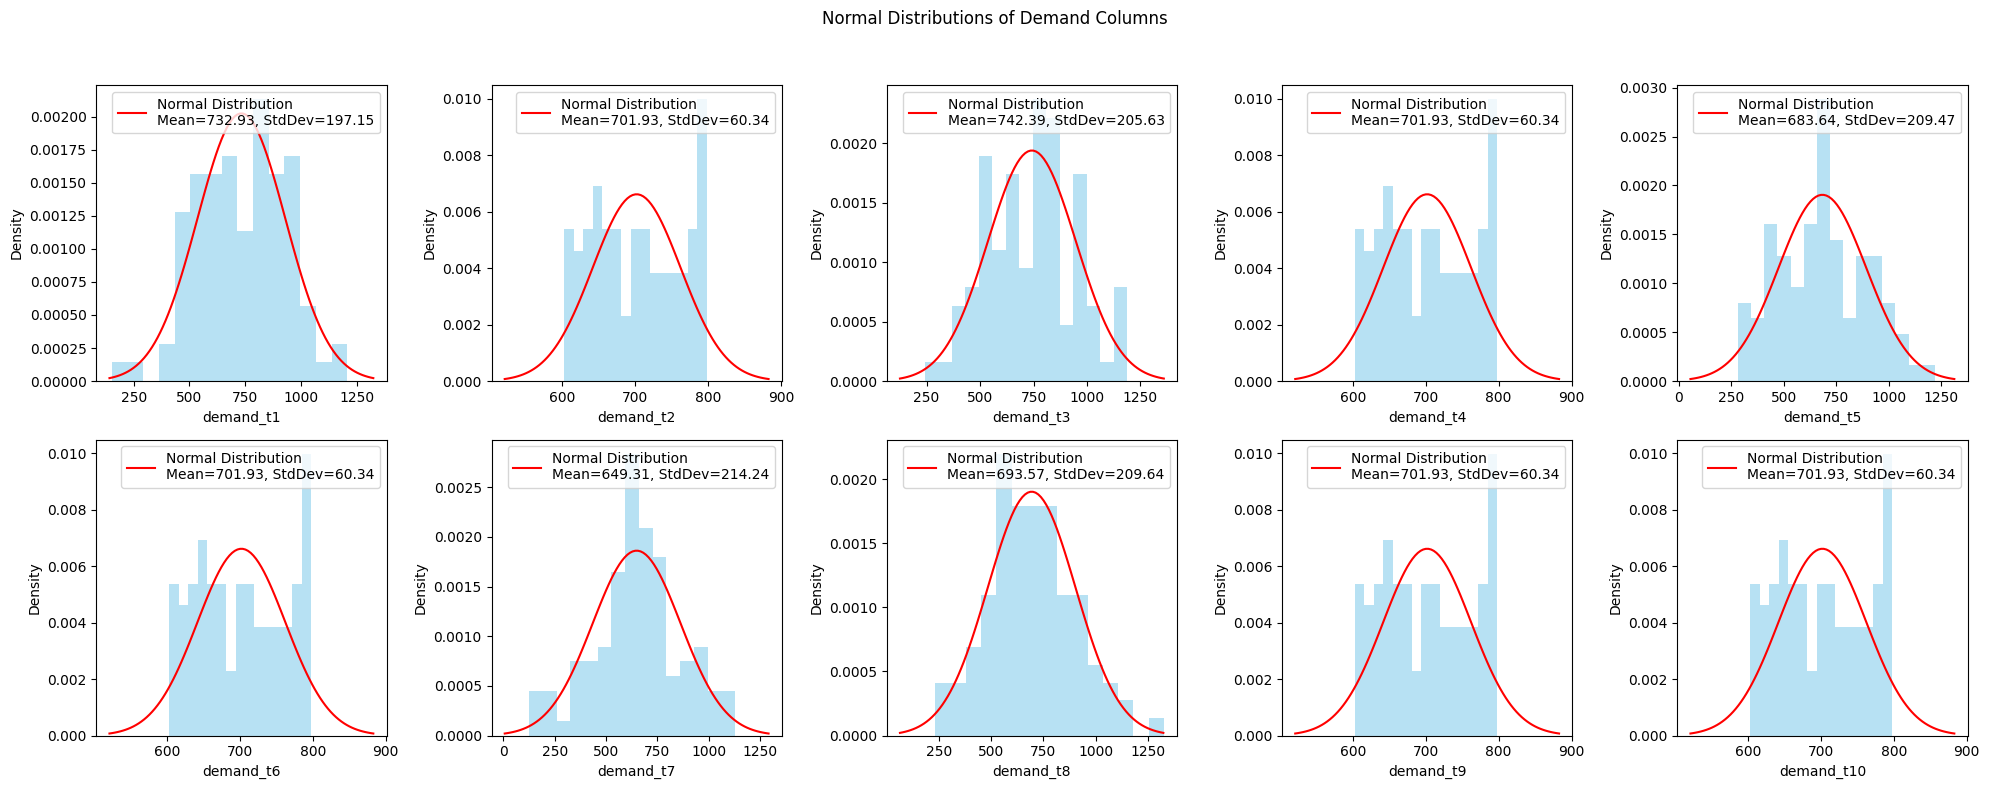

In [4165]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [4166]:
demand_df.cov()

demand_t1    demand_t2     demand_t3    demand_t4  \
demand_t1   39258.794467  3096.955969  25996.243564  3096.955994   
demand_t2    3096.955969  3677.223494   3379.514543  3677.223492   
demand_t3   25996.243564  3379.514543  42712.126495  3379.514591   
demand_t4    3096.955994  3677.223492   3379.514591  3677.223491   
demand_t5   -9520.640453  3637.317771 -16570.159478  3637.317786   
demand_t6    3096.955986  3677.223494   3379.514568  3677.223492   
demand_t7   -1415.936841  5189.545175 -17823.741584  5189.545161   
demand_t8   -7775.841547  5051.731827   1319.697894  5051.731844   
demand_t9    3096.955986  3677.223494   3379.514568  3677.223492   
demand_t10   3096.955986  3677.223494   3379.514568  3677.223492   

               demand_t5    demand_t6     demand_t7     demand_t8  \
demand_t1   -9520.640453  3096.955986  -1415.936841  -7775.841547   
demand_t2    3637.317771  3677.223494   5189.545175   5051.731827   
demand_t3  -16570.159478  3379.514568 -17823.741584   1319.697894   
demand_t4    3637.317786  3677.223492   5189.545161   5051.731844   
demand_t5   44318.927069  3637.317783  17926.313837  14873.471647   
demand_t6    3637.317783  3677.223494   5189.545180   5051.731828   
demand_t7   17926.313837  5189.545180  46362.979377   5629.711446   
demand_t8   14873.471647  5051.731828   5629.711446  44393.678349   
demand_t9    3637.317783  3677.223494   5189.545180   5051.731828   
demand_t10   3637.317783  3677.223494   5189.545180   5051.731828   

              demand_t9   demand_t10  
demand_t1   3096.955986  3096.955986  
demand_t2   3677.223494  3677.223494  
demand_t3   3379.514568  3379.514568  
demand_t4   3677.223492  3677.223492  
demand_t5   3637.317783  3637.317783  
demand_t6   3677.223494  3677.223494  
demand_t7   5189.545180  5189.545180  
demand_t8   5051.731828  5051.731828  
demand_t9   3677.223494  3677.223494  
demand_t10  3677.223494  3677.223494

In [4167]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1    demand_t2    demand_t3    demand_t4    demand_t5  \
demand_t1    741.205533  3096.955969  3764.899529  3096.955994  5990.307265   
demand_t2   3096.955969  3677.223494  3379.514543  3677.223492  3637.317771   
demand_t3   3764.899529  3379.514543  2712.126495  3379.514591   569.507063   
demand_t4   3096.955994  3677.223492  3379.514591  3677.223491  3637.317786   
demand_t5   5990.307265  3637.317771   569.507063  3637.317786  4318.927069   
demand_t6   3096.955986  3677.223494  3379.514568  3677.223492  3637.317783   
demand_t7   2546.975243  5189.545175  4237.986690  5189.545161  5913.900212   
demand_t8   3261.904881  5051.731827   897.196053  5051.731844  3112.684153   
demand_t9   3096.955986  3677.223494  3379.514568  3677.223492  3637.317783   
demand_t10  3096.955986  3677.223494  3379.514568  3677.223492  3637.317783   

              demand_t6    demand_t7    demand_t8    demand_t9   demand_t10  
demand_t1   3096.955986  2546.975243  3261.904881  3096.955986  3096.955986  
demand_t2   3677.223494  5189.545175  5051.731827  3677.223494  3677.223494  
demand_t3   3379.514568  4237.986690   897.196053  3379.514568  3379.514568  
demand_t4   3677.223492  5189.545161  5051.731844  3677.223492  3677.223492  
demand_t5   3637.317783  5913.900212  3112.684153  3637.317783  3637.317783  
demand_t6   3677.223494  5189.545180  5051.731828  3677.223494  3677.223494  
demand_t7   5189.545180  6362.979377  4072.056355  5189.545180  5189.545180  
demand_t8   5051.731828  4072.056355  4393.678349  5051.731828  5051.731828  
demand_t9   3677.223494  5189.545180  5051.731828  3677.223494  3677.223494  
demand_t10  3677.223494  5189.545180  5051.731828  3677.223494  3677.223494

### Validate the corr matrix of damand_df is close to original setting


In [4168]:
demand_df

demand_t1   demand_t2    demand_t3   demand_t4   demand_t5   demand_t6  \
0   151.884513  662.359175   373.449914  662.359176  603.661572  662.359176   
1   690.757690  739.268698   605.789384  739.268697  663.379598  739.268698   
2   901.800324  675.550366  1189.301217  675.550368  349.369033  675.550368   
3   820.717174  635.920735   640.361016  635.920735  919.186957  635.920736   
4   820.614599  604.935747   876.198929  604.935746  320.722599  604.935746   
..         ...         ...          ...         ...         ...         ...   
95  628.883809  644.863406   772.218017  644.863405  501.149908  644.863406   
96  687.214811  619.568897   548.825431  619.568897  411.763502  619.568897   
97  750.703126  772.438303   908.187430  772.438304  467.789308  772.438303   
98  782.224299  794.583898   672.970492  794.583898  727.783478  794.583898   
99  804.902953  792.166932   752.912471  792.166932  849.410673  792.166932   

     demand_t7    demand_t8   demand_t9  demand_t10  
0   997.022309   731.361181  662.359176  662.359176  
1   855.929187   455.659220  739.268698  739.268698  
2   403.527760   233.749522  675.550368  675.550368  
3   682.179422   549.326221  635.920736  635.920736  
4   567.184541  1019.060190  604.935746  604.935746  
..         ...          ...         ...         ...  
95  415.470159   393.715788  644.863406  644.863406  
96  660.121800   482.167636  619.568897  619.568897  
97  915.073121   592.117469  772.438303  772.438303  
98  869.410518   954.264967  794.583898  794.583898  
99  968.709585   865.391786  792.166932  792.166932  

[100 rows x 10 columns]

In [4169]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.257755   0.634843   0.257755  -0.228246   0.257755   
demand_t2    0.257755   1.000000   0.269661   1.000000   0.284922   1.000000   
demand_t3    0.634843   0.269661   1.000000   0.269661  -0.380852   0.269661   
demand_t4    0.257755   1.000000   0.269661   1.000000   0.284922   1.000000   
demand_t5   -0.228246   0.284922  -0.380852   0.284922   1.000000   0.284922   
demand_t6    0.257755   1.000000   0.269661   1.000000   0.284922   1.000000   
demand_t7   -0.033189   0.397451  -0.400532   0.397451   0.395467   0.397451   
demand_t8   -0.186259   0.395385   0.030307   0.395385   0.335318   0.395385   
demand_t9    0.257755   1.000000   0.269661   1.000000   0.284922   1.000000   
demand_t10   0.257755   1.000000   0.269661   1.000000   0.284922   1.000000   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1   -0.033189  -0.186259   0.257755    0.257755  
demand_t2    0.397451   0.395385   1.000000    1.000000  
demand_t3   -0.400532   0.030307   0.269661    0.269661  
demand_t4    0.397451   0.395385   1.000000    1.000000  
demand_t5    0.395467   0.335318   0.284922    0.284922  
demand_t6    0.397451   0.395385   1.000000    1.000000  
demand_t7    1.000000   0.124091   0.397451    0.397451  
demand_t8    0.124091   1.000000   0.395385    0.395385  
demand_t9    0.397451   0.395385   1.000000    1.000000  
demand_t10   0.397451   0.395385   1.000000    1.000000

In [4170]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [4171]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [4172]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (50, 10), Test size: (50, 10)
train.head(): 
    demand_t1   demand_t2   demand_t3   demand_t4   demand_t5   demand_t6  \
0  683.340825  627.380054  785.169585  627.380054  775.069542  627.380054   
1  650.746838  658.429505  592.826281  658.429505  865.545497  658.429505   
2  151.884513  662.359175  373.449914  662.359176  603.661572  662.359176   
3  602.266782  641.494015  521.291910  641.494015  989.385549  641.494015   
4  871.872654  789.474119  748.382894  789.474119  566.857944  789.474118   

     demand_t7   demand_t8   demand_t9  demand_t10  
0   133.873881  618.674554  627.380054  627.380054  
1   759.278949  572.407968  658.429505  658.429505  
2   997.022309  731.361181  662.359176  662.359176  
3   722.243660  780.162200  641.494015  641.494015  
4  1033.817914  759.074151  789.474118  789.474118  

Fold 2:
Train size: (50, 10), Test size: (50, 10)
train.head(): 
     demand_t1   demand_t2    demand_t3   demand_t4   demand_t5   demand_t6  \
0   553.9

In [4173]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [4174]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [4175]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 7114.030393446125
std of sum: 705.1372538313861
95.0 percentile of sum: 8273.877962909282
Q_star: 8273.877962909282

mean of sum: 6885.552476875933
std of sum: 707.9490457900015
95.0 percentile of sum: 8050.02503254045
Q_star: 8050.02503254045



## Data3: Qk hat df


### Functions


In [4176]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [4177]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [4178]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [4179]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [4180]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [4181]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [4182]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [4183]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

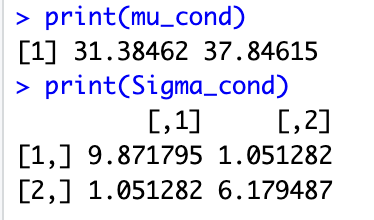
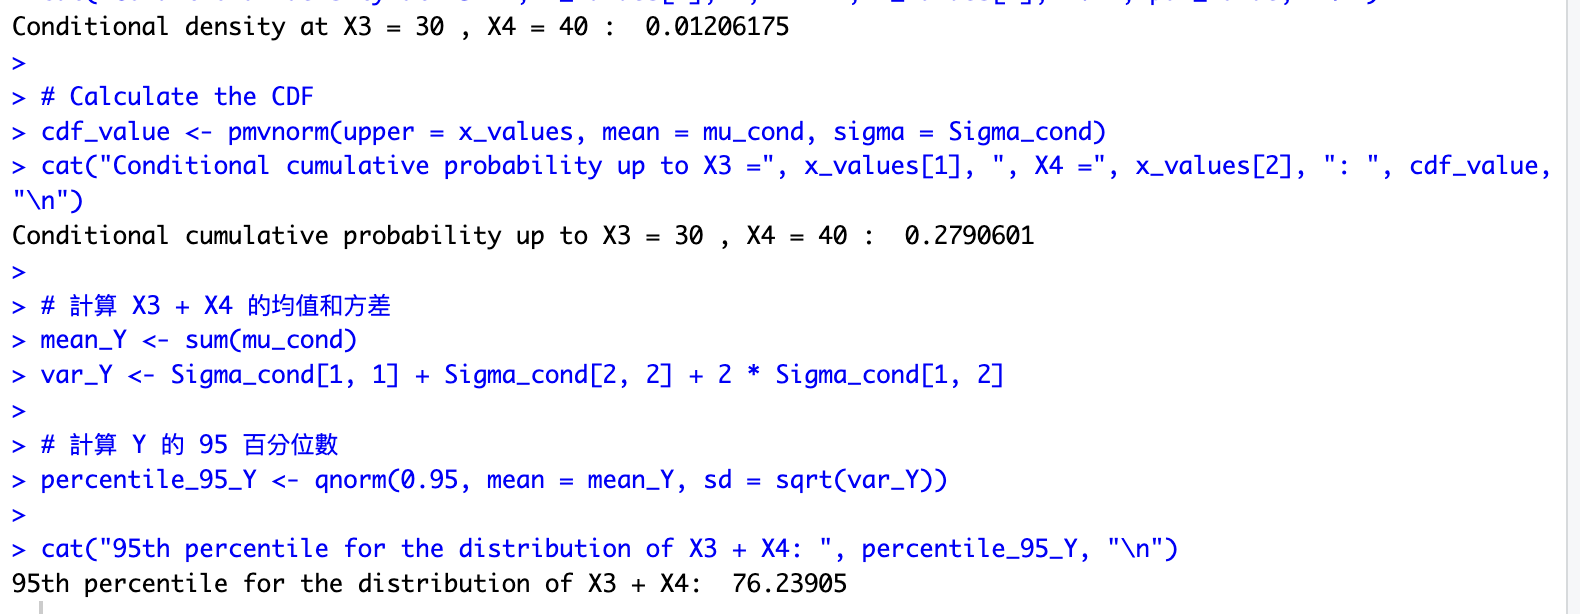


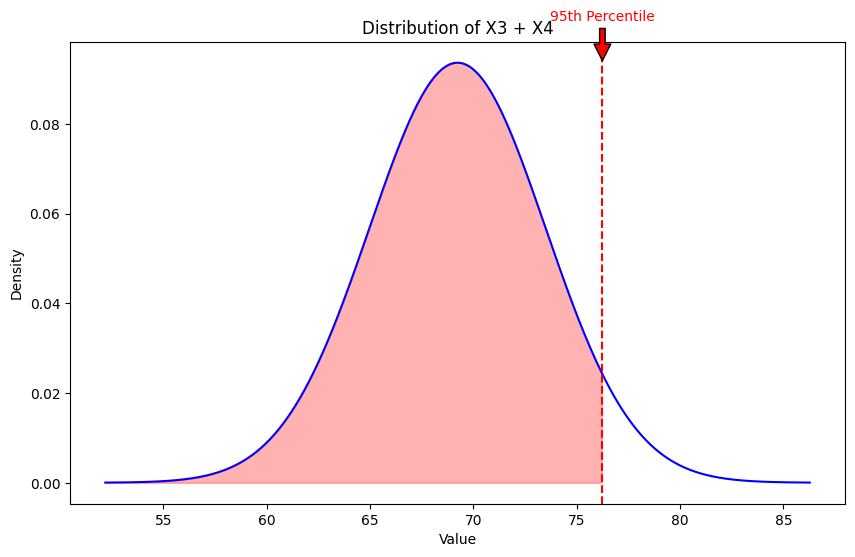

In [4184]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


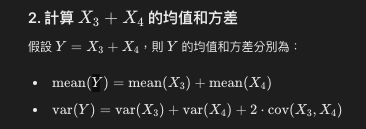


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [4185]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.011044263785324
模擬計算的Y的方差: 2.971568550026781


### Calculate Qk hat for 2~T-1 of demand_df_train


In [4186]:
demand_df_train = demand_folds[0][0]

In [4187]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [4188]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787

In [4189]:
Qk_hat_df

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   7184.283049  6690.958164  6689.805117  6689.805122  6242.372033   
1   8035.682132  7881.538157  7889.447352  7889.447344  7547.440155   
2   8369.121452  7422.573911  7399.254862  7399.254868  7145.479343   
3   8241.013165  6966.789437  6975.192711  6975.192703  7195.417249   
4   8240.851100  6661.199333  6653.300613  6653.300604  6296.569146   
..          ...          ...          ...          ...          ...   
95  7937.923759  6901.081935  6893.073430  6893.073422  6620.695434   
96  8030.084520  6698.472269  6706.933450  6706.933447  6228.821919   
97  8130.393637  8256.671826  8248.029207  8248.029208  7779.043869   
98  8180.195890  8500.309438  8509.008029  8509.008026  8192.363683   
99  8216.027298  8494.670382  8498.992373  8498.992369  8397.800699   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0   6242.372035  6482.531653  6169.175370  
1   7547.440156  7510.990423  6967.858568  
2   7145.479345  7143.596497  6455.499694  
3   7195.417250  7135.940371  6791.374468  
4   6296.569144  6379.080384  6628.459590  
..          ...          ...          ...  
95  6620.695435  6463.411901  5935.754710  
96  6228.821918  6180.672407  5887.937667  
97  7779.043869  7950.847783  7496.061973  
98  8192.363682  8089.935194  7979.573245  
99  8397.800698  8439.382896  8202.162128  

[100 rows x 8 columns]

### Plot the distribuction


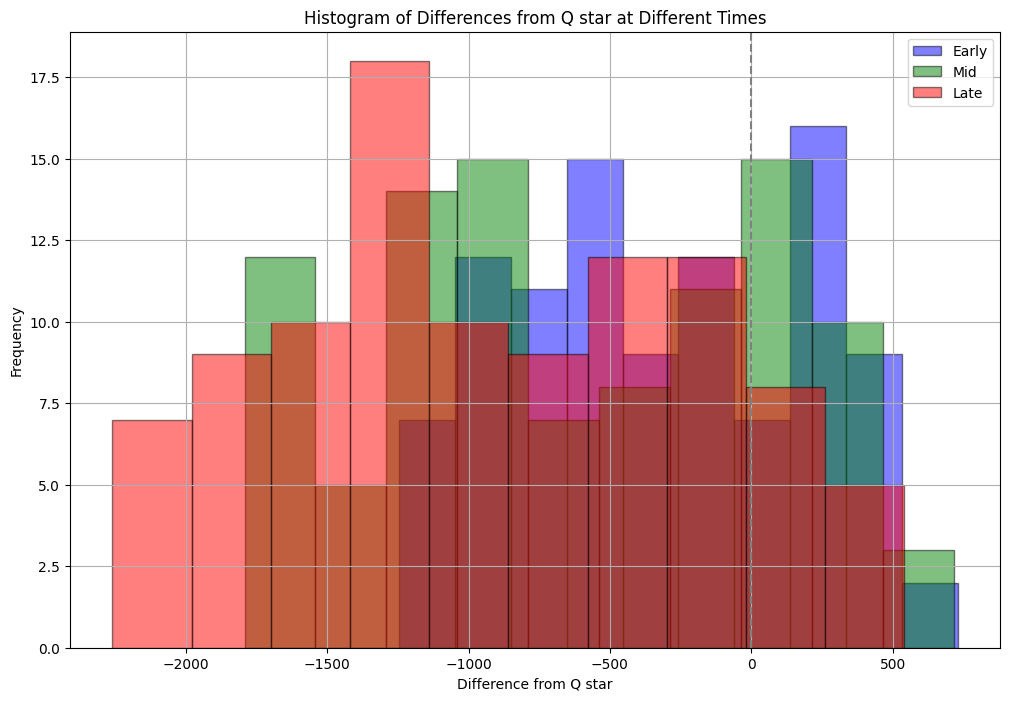

Q_star is: 8050.02503254045
Early bias: -317.8942569771293
Mid bias: -606.9883080518309
Late bias: -894.2614992076891


In [4190]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

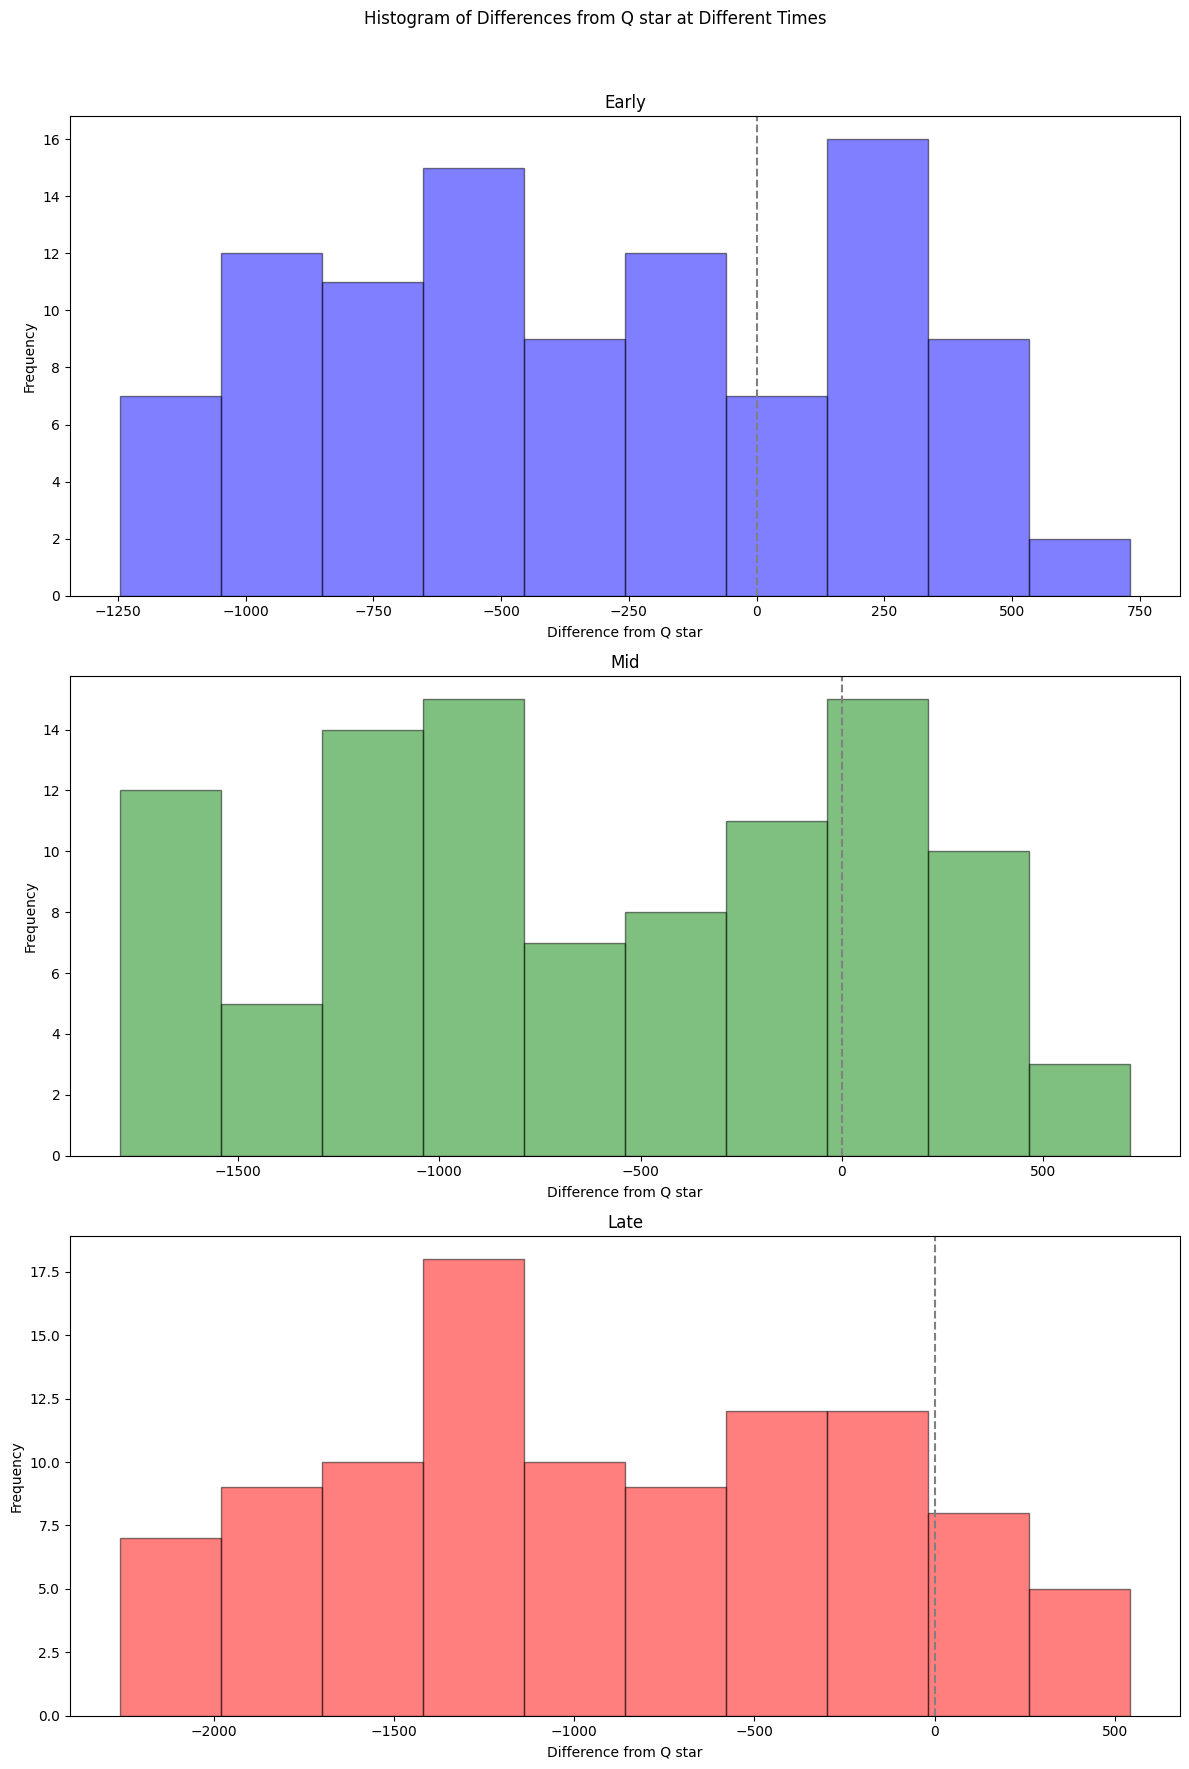

In [4191]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## Validation

In [4192]:
import gurobipy as gp
from gurobipy import GRB

# 初始化模型
# model = gp.Model("Test_r_R_relationship")
model = gp.Model(env=env)

# 設定參數
K = 4  # 候選數量
i = 0  # 單個 i 的例子

# 定義變數
r_vars = model.addVars(K, lb=0.0, ub=1.0, name="r_vars")  # r_{i,k}
R_vars = model.addVars(K, vtype=GRB.BINARY, name="R_vars")  # R_{i,k}
max_r_helper = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")  # 最大值輔助變數

# 假設 exp_tau_vars 是已知的輸入數值
exp_tau_vars = [0.1, 0.3, 0.5, 0.2]  # 例子數值

# 限制式 1: 定義 r_vars 與 exp_tau_vars 的關係
for k in range(K):
    model.addConstr(
        r_vars[k] * sum(exp_tau_vars) == exp_tau_vars[k],
        name=f"softmax_relation_{k}",
    )

# 限制式 2: 確保 r_vars 的加總為 1
model.addConstr(gp.quicksum(r_vars[k] for k in range(K)) == 1, name="sum_r_constraint")

# 限制式 3: 找出 r_vars 中的最大值
model.addGenConstrMax(
    max_r_helper, [r_vars[k] for k in range(K)], name="max_r_constraint"
)

# 限制式 4: 確保 R_vars 對應到最大值
for k in range(K):
    model.addGenConstrIndicator(
        R_vars[k], 1, r_vars[k] == max_r_helper, name=f"indicator_R_{k}"
    )

# 限制式 5: 確保僅有一個 R_vars[k] 為 1
model.addConstr(
    gp.quicksum(R_vars[k] for k in range(K)) == 1, name="unique_R_constraint"
)

# 設定目標函數（範例：最大化 max_r_helper）
model.setObjective(max_r_helper, GRB.MAXIMIZE)

# 求解模型
model.optimize()

# 輸出結果
if model.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
    print(f"max_r_helper: {max_r_helper.X}")
    print("r_vars:")
    for k in range(K):
        print(f"  r_vars[{k}]: {r_vars[k].X}")
    print("R_vars:")
    for k in range(K):
        print(f"  R_vars[{k}]: {R_vars[k].X}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 6 rows, 9 columns and 12 nonzeros
Model fingerprint: 0x2fc3cf89
Model has 5 general constraints
Variable types: 5 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 6 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0.454545 
No other solutions better than 0.454545

Optimal solution found (tolerance 1.00e-04)
Best objective 4.5454

## S0 - One-time Procurement


In [4193]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [4194]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [4195]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [4196]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [4197]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [4198]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):
    print(
        f"+++++++++++++++++++++++++++++++++++++++ THis is R={assigned_R} +++++++++++++++++++++++++++++++++++++++++++++++++"
    )
    with gp.Model("profit_maximization", env=env) as model:
        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Decision Variables =======================
        alphas = model.addVars(
            features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="alphas"
        )
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")

        f_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, ub=GRB.INFINITY, name="f_var"
        )
        F_vars = model.addVars(len(demand_df_train), lb=0, ub=1, name="Fraction")

        Q0_vars = model.addVars(
            len(demand_df_train), lb=0.0, ub=(Q_star + 1), name="Q0_var"
        )
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        # ======================= Model Constraints =======================
        for i, row in demand_df_train.iterrows():
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i].tolist()
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            model.addConstr(F_vars[i] >= 0, name=f"Fraction_lower_bound_{i}")
            model.addConstr(F_vars[i] <= 1, name=f"Fraction_upper_bound_{i}")

            # Calculate F using logistic regression
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(xvar=f_vars[i], yvar=F_vars[i])

            # Calculate initial order quantity
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star)

            # Define demand variables for before and after reorder point
            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # Calculate first period sales and lost sales
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # Calculate lost sales
            Lost_0_expr = total_demand_before_R - Q0_vars[i]
            Lost_0_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_expr_{i}")
            model.addConstr(Lost_0_var == Lost_0_expr)
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_var, 0], name=f"max_lost_constr_{i}"
            )

            # Calculate inventory left after first period
            left_0 = Q0_vars[i] - Sold_0s[i]

            # Calculate Q1 based on reorder point estimate
            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # Calculate second period sales and lost sales
            total_stock_second_period = Q1_vars[i] + left_0
            total_stock_second_period_var = model.addVar(
                lb=0, name=f"total_stock_second_period_{i}"
            )
            model.addConstr(total_stock_second_period_var == total_stock_second_period)

            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, total_stock_second_period_var],
                name=f"min_sales2_constr_{i}",
            )

            # Calculate second period lost sales
            Lost_1_expr = total_demand_after_R - total_stock_second_period_var
            Lost_1_var = model.addVar(lb=-GRB.INFINITY, name=f"Lost_1_expr_{i}")
            model.addConstr(Lost_1_var == Lost_1_expr)

            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_var, 0], name=f"max_lost2_constr_{i}"
            )

            model.addConstr(Left_1s[i] == total_stock_second_period_var - Sold_1s[i])

            # # Calculate holding costs directly in profit equation
            # holding_cost_1 = (
            #     (Q0_vars[i] + total_stock_second_period) * (assigned_R + 2 - 1) / 2
            # )
            # holding_cost_2 = (
            #     (total_stock_second_period + Left_1s[i]) * (T - (assigned_R + 2)) / 2
            # )

            # Calculate profit
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
                    - (cost - salvage_value) * Left_1s[i]  # Salvage cost
                    # - holding_cost * (holding_cost_1 + holding_cost_2)  # Holding cost
                )
            )

        # Set objective
        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s2_model_debug.lp")
        model.write("s2_model.mps")

        # Solve model
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL or model.status == GRB.TIME_LIMIT:
                print(f"Model status: {model.status}")

                # Collect results
                alpha_values = np.array([alpha.X for alpha in alphas.values()])

                results = {
                    "losses": [],
                    "lefts": [],
                    "profits": [],
                    "operation_profits": [],
                    "Q0s": [],
                    "Q1s": [],
                    "Fs": [],
                }

                for i in range(len(demand_df_train)):
                    sold0, sold1 = Sold_0s[i].X, Sold_1s[i].X
                    lost0, lost1 = Lost_0s[i].X, Lost_1s[i].X
                    left1 = Left_1s[i].X

                    # Record results
                    results["losses"].append(lost0 + lost1)
                    results["lefts"].append(left1)
                    results["operation_profits"].append(
                        (price - cost) * (sold0 + sold1)
                    )
                    results["profits"].append(profits_vars[i].X)
                    results["Q0s"].append(Q0_vars[i].X)
                    results["Q1s"].append(Q1_vars[i].X)
                    results["Fs"].append(F_vars[i].X)

                    print(f"\nObservation {i+1}:")
                    print(f"Reorder day: {assigned_R+2}")
                    print(f"Profit: {profits_vars[i].X:.2f}")

                return (
                    [assigned_R] * len(demand_df_train),  # Fixed R for all observations
                    results["losses"],
                    results["lefts"],
                    results["profits"],
                    results["operation_profits"],
                    alpha_values,
                    results["Fs"],
                    results["Q0s"],
                    results["Q1s"],
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4199]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    best_R_F_per_demand = {
        "index": [],
        "best_R": [],
        "best_F": [],
        "best_profit": [],
    }

    for assigned_T in assigned_Ts:
        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")
            continue

        (
            all_Rs,
            losses,
            lefts,
            profits,
            operation_profits,
            alpha_values,
            F_vars,
            Q0_vars,
            Q1_vars,
        ) = result

        # 計算平均值
        average_losses = sum(losses) / len(losses) if losses else 0
        average_lefts = sum(lefts) / len(lefts) if lefts else 0
        average_profits = sum(profits) / len(profits) if profits else 0
        average_operation_profits = (
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        )

        # 將結果存儲到字典中
        results_dict["R(T)"].append(assigned_T)
        results_dict["R"].append(all_Rs)
        results_dict["average_losses"].append(average_losses)
        results_dict["average_lefts"].append(average_lefts)
        results_dict["average_profits"].append(average_profits)
        results_dict["average_operation_profits"].append(average_operation_profits)
        results_dict["alpha_values"].append(alpha_values)
        results_dict["F_vars"].append(F_vars)
        results_dict["Q0_vars"].append(Q0_vars)
        results_dict["Q1_vars"].append(Q1_vars)

        print(f"The average profits is {average_profits}")

        if max_profit is None or max_profit < average_profits:
            print(f"max_profit is changed from {max_profit} to {average_profits}")
            max_profit = average_profits
            max_profit_stimulation_result = {
                "R": all_Rs,
                "F": F_vars,
                "profits": profits,
                "losses": losses,
                "lefts": lefts,
                "operation_profits": operation_profits,
                "Q0": Q0_vars,
                "Q1": Q1_vars,
            }

        # 針對每筆 demand 找到最佳的 R 和 F
        for i in range(len(demand_df_train)):
            current_profit = profits[i]
            current_F = F_vars[i]
            current_R = all_Rs[i]

            # 如果這筆 demand 的最佳 profit 尚未存入，或比之前的更好，則更新
            if (
                i not in best_R_F_per_demand["index"]
                or current_profit > best_R_F_per_demand["best_profit"][i]
            ):
                if i not in best_R_F_per_demand["index"]:
                    best_R_F_per_demand["index"].append(i)
                    best_R_F_per_demand["best_R"].append(current_R)
                    best_R_F_per_demand["best_F"].append(current_F)
                    best_R_F_per_demand["best_profit"].append(current_profit)
                else:
                    best_R_F_per_demand["best_R"][i] = current_R
                    best_R_F_per_demand["best_F"][i] = current_F
                    best_R_F_per_demand["best_profit"][i] = current_profit

    return (
        pd.DataFrame(results_dict).sort_values(by="average_profits", ascending=False),
        pd.DataFrame(max_profit_stimulation_result),
        pd.DataFrame(best_R_F_per_demand),
    )

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [4200]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # 計算 Holding_Cost_0
            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4201]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [4202]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4203]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [4204]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")
        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )
        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            # lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項

                # 定義指數變數
                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{p}")
                neg_tau_var = model.addVar(
                    lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(lb=0, name=f"sum_exp_tau_vars_{i}")
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            eps = 1e-10
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] >= max_r_helpers - eps
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            # assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            # model.addConstr(
            #     assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
            #     name=f"Calc_assigned_R_{i}",
            # )

            # # 計算 Holding_Cost_0
            # model.addConstr(
            #     Holding_Cost_0s[i]
            #     == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
            #     name=f"Constr_Holding_Cost_0_{i}",
            # )

            # # 計算 Holding_Cost_1
            # model.addConstr(
            #     Holding_Cost_1s[i]
            #     == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
            #     name=f"Constr_Holding_Cost_1_{i}",
            # )

            # model.addConstr(
            #     profits_vars[i]
            #     == (
            #         (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
            #         - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
            #         - (cost - salvage_value) * Left_1s[i]  # left cost
            #         # - holding_cost
            #         # * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
            #     ),
            #     name=f"Profit_Constraint_{i}",
            # )
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        model.write("s6_model_debug.lp")
        model.write("s6_model.mps")

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        print(
                            f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    for t in range(2):
                        if t == 0:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                            )
                        else:
                            print(
                                f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                            )

                    print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4205]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [4206]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 定義輔助變數
            Sold_0_aux = model.addVar(name=f"Sold_0_aux_{i}")
            Left_0_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(name=f"Lost_0_aux_{i}")
            Sold_1_aux = model.addVar(name=f"Sold_1_aux_{i}")
            Left_1_aux = model.addVar(name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0_aux,
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )
            model.addConstr(Sold_0s[i] == Sold_0_aux, name=f"Constr_Sold_0_eq_aux_{i}")

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1_aux,
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )
            model.addConstr(Sold_1s[i] == Sold_1_aux, name=f"Constr_Sold_1_eq_aux_{i}")

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4207]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [4208]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        Holding_Cost_0s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            lb=0,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train), lb=0, name="Total_Demand_from_k_to_T"
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(len(demand_df_train), K, lb=-GRB.INFINITY, name="tau")
        r_vars = model.addVars(len(demand_df_train), K, lb=0.0, ub=1.0, name="r")
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")
        Q_hats = model.addVars(
            len(Qk_hat_df),
            lb=0.0,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df), lb=-GRB.INFINITY, name=f"Q_hat_adjusted"
        )

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):
                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                exp_tau_var = model.addVar(lb=0, name=f"exp_tau_var_{i}_{k}")
                # neg_tau_var = model.addVar(
                #     lb=-GRB.INFINITY, ub=0, name=f"neg_tau_var_{i}_{k}"
                # )

                # model.addConstr(
                #     neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                # )
                # model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                model.addGenConstrExp(xvar=tau_vars[i, k], yvar=exp_tau_var)
                exp_tau_vars.append(exp_tau_var)

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )
                
            model.addConstr(
                gp.quicksum(r_vars[i, k] for k in range(K)) == 1,
                name=f"sum_r_{i}",
            )
            max_r_helpers = model.addVar(lb=0.0, ub=1.0, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            # 確保 R_vars 的邏輯行為
            for k in range(K):
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] == max_(Q_hat_adjusteds[i], 0),
                name=f"Max_Constraint_{i}",
            )

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )

            # ### k~T 的需求量
            model.addConstr(
                total_demand_from_k_to_T_vars[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_up_to_k_minus_1_vars[i], Q0_vars[i]],
                name=f"Constr_Sold_0_min_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[k, j].X for j in range(features_num + 1)] for k in range(K)]
                )
                print(f"beta_values:\n{beta_values}")

                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_rs = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    # print("----------------------------------------------")
                    # print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    rs = []
                    for k in range(K):
                        rs.append(r_vars[i, k].X)
                        R_value = R_vars[i, k].X
                        # print(
                        #     f"第 {k+2} 天補貨策略: R_vars = {R_value}, r_vars = {rs[k]}"
                        # )

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    # print(f"*** 於第[{reorder_day}]天進貨 ***\n")

                    all_Rs.append(reorder_day)
                    all_rs.append(rs)

                    demand_row = demand_df_train.iloc[i]

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    # print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                # print("==========================================")
                # print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4209]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S10 - ML Model

In [4210]:
def __fully_flexible_beta_with_softmax_10(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    # beta_values,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)
        model.setParam("IntFeasTol", 1e-9)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(features_num + 1, lb=-GRB.INFINITY, name="alphas")
        # betas = model.addVars(K, features_num + 1, lb=-GRB.INFINITY, name="betas")

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_0")
        Left_0s = model.addVars(len(demand_df_train), lb=0.0, name="Left_0")
        Lost_0s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_0")

        Sold_1s = model.addVars(len(demand_df_train), lb=0.0, name="Sold_1")
        Left_1s = model.addVars(len(demand_df_train), lb=0.0, name="Left_1")
        Lost_1s = model.addVars(len(demand_df_train), lb=0.0, name="Lost_1")

        # Holding_Cost_0s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_0"
        # )

        # Holding_Cost_1s = model.addVars(
        #     len(demand_df_train), lb=0.0, name="Holding_Cost_1"
        # )

        profits_vars = model.addVars(
            len(demand_df_train), lb=-GRB.INFINITY, name="profits_vars"
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            lb=0,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(len(demand_df_train), lb=-GRB.INFINITY, name="f_var")
        F_vars = model.addVars(
            len(demand_df_train), lb=0, ub=1, name="Fraction_for_second_order_amount"
        )
        Q0_vars = model.addVars(
            len(demand_df_train), lb=0, ub=(Q_star + 1), name="Q0_var"
        )

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(len(Qk_hat_df), lb=0.0, name="Q1_var")

        # 載入 Logistic Regression 模型
        logistic_model = joblib.load("logistic_regression_best_R.pkl")
        R_pred = logistic_model.predict(training_df)
        print("Predicted R Categories:", R_pred)

        # ======================= Start Stimulation! =======================

        for i, _ in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            assigned_R = R_pred[i]  # assigned R for this observation from trained model

            # ============ Model 3: re-estimate order-up-to-level =================

            Q_hat = Qk_hat_df_row[assigned_R]
            Q_hat_adjusted = Q_hat - Q0_vars[i]
            Q_hat_adjusted_var = model.addVar(
                lb=-GRB.INFINITY, name=f"Q_hat_adjusted_{i}"
            )
            model.addConstr(Q_hat_adjusted_var == Q_hat_adjusted)

            model.addGenConstrMax(
                Q1_vars[i], [Q_hat_adjusted_var, 0], name=f"max_Q1_constr_{i}"
            )

            # =================== Model 4: Maximum Profit Model ===================

            total_demand_before_R = demand_row[: assigned_R + 1].sum()
            total_demand_after_R = demand_row[assigned_R + 1 :].sum()

            # 定義輔助變數
            Left_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_0_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")
            Left_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Left_0_aux_{i}")
            Lost_1_aux = model.addVar(lb=-GRB.INFINITY, name=f"Lost_0_aux_{i}")

            # 計算 Sold_0，為 total_demand_up_to_k_minus_1_vars 和 Q0_vars 的最小值
            model.addGenConstrMin(
                Sold_0s[i],
                [total_demand_before_R, Q0_vars[i]],
                name=f"min_sales_constr_{i}",
            )

            # 計算 Left_0，為 max(Q0_vars[i] - Sold_0s[i], 0)
            model.addConstr(
                Left_0_aux == Q0_vars[i] - Sold_0s[i],
                name=f"Constr_Left_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_0s[i], [Left_0_aux, 0], name=f"Constr_Left_0_max_{i}"
            )

            # 計算 Lost_0，為 max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
            model.addConstr(
                Lost_0_aux == total_demand_before_R - Q0_vars[i],
                name=f"Constr_Lost_0_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_0s[i], [Lost_0_aux, 0], name=f"Constr_Lost_0_max_{i}"
            )

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i],
                name=f"Constr_Q1_plus_left_{i}",
            )

            # 計算 Sold_1，為 total_demand_from_k_to_T_vars 和 Q1_plus_lefts 的最小值
            model.addGenConstrMin(
                Sold_1s[i],
                [total_demand_after_R, Q1_plus_lefts[i]],
                name=f"Constr_Sold_1_min_{i}",
            )

            # 計算 Left_1，為 max(Q1_plus_lefts[i] - Sold_1s[i], 0)
            model.addConstr(
                Left_1_aux == Q1_plus_lefts[i] - Sold_1s[i],
                name=f"Constr_Left_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Left_1s[i], [Left_1_aux, 0], name=f"Constr_Left_1_max_{i}"
            )

            # 計算 Lost_1，為 max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)
            model.addConstr(
                Lost_1_aux == total_demand_after_R - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_diff_aux_{i}",
            )
            model.addGenConstrMax(
                Lost_1s[i], [Lost_1_aux, 0], name=f"Constr_Lost_1_max_{i}"
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )
        model.write("s4_model_debug.lp")
        model.write("s4_model.mps")
        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                f_values = np.array([f.X for _, f in f_vars.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = R_pred
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                # all_holding_costs_0 = []
                # all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    # Holding_Cost_0 = Holding_Cost_0s[i].X
                    # Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    # all_holding_costs_0.append(Holding_Cost_0)
                    # all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    demand_row = demand_df_train.iloc[i]

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [4211]:
def fully_flexible_beta_with_softmax_10(
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
    # beta_values,
):

    result = __fully_flexible_beta_with_softmax_10(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
        # beta_values=beta_values,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result

        print(f"all_Rs: {all_Rs}")

        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=None,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=None,
            holding_costs_0s=None,
            holding_costs_1s=None,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [4212]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [4213]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [4214]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [4215]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [4216]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [4217]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [4218]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [4219]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S10 - ML Model

In [4220]:
def cal_test_fully_flexible_beta_with_softmax_10(
    alphas,
    # betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # load the model of R
    logistic_model = joblib.load("logistic_regression_best_R.pkl")
    R_pred = logistic_model.predict(testing_df)
    print("Predicted R Categories:", R_pred)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================
        R_vars[i, R_pred[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        # assigned_R = max_r_index[i]

        # all_holding_costs_0[i] = (
        #     (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        # )
        # all_holding_costs_1[i] = (
        #     (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        # )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            # - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            # "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R": R_pred,
            "R(T)": [x + 2 for x in R_pred],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [4221]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202502052119

In [4222]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.3


In [4223]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [4224]:
training_df.shape

(50, 4)

In [4225]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 7114.030393446125
std of sum: 705.1372538313861
30.0 percentile of sum: 6744.256056007406
Q_star: 6744.256056007406


In [4226]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0   6741.273064  6107.765062  6112.452874  6112.452872  6376.740512   
1   6681.805711  6378.374788  6372.732059  6372.732060  6628.118613   
2   5771.637143  5965.763087  5966.514773  5966.514782  5834.894336   
3   6593.354406  6170.928406  6163.319375  6163.319380  6558.629105   
4   7085.247216  7844.464794  7837.067702  7837.067699  7638.572483   
5   6438.294415  6380.483029  6377.010747  6377.010747  6427.096967   
6   6344.838170  6066.117982  6047.570668  6047.570663  5943.989504   
7   6622.194215  6605.022401  6613.851906  6613.851914  6703.253230   
8   7389.509898  7706.491462  7705.900829  7705.900831  7584.217972   
9   7209.338153  7554.054288  7556.968916  7556.968921  7924.041474   
10  6613.116498  7693.778418  7683.712928  7683.712915  7972.306920   
11  7123.515877  6444.679985  6431.883242  6431.883244  6515.246549   
12  6748.369740  6391.193898  6399.092687  6399.092684  6375.213606   
13  6384.127356  6795.995981  6807.140322  6807.140328  6970.310106   
14  7275.366230  7797.336486  7792.365866  7792.365873  7604.797673   
15  7453.263559  6481.966754  6490.945059  6490.945064  6509.792372   
16  6987.791136  6966.752990  6966.577712  6966.577716  7087.817606   
17  6243.466604  6267.837208  6271.331000  6271.331002  5995.350032   
18  6749.918612  5887.367798  5902.407937  5902.407929  5693.502491   
19  6990.264012  7202.361721  7193.585976  7193.585961  7068.559778   
20  7298.071489  7725.007042  7729.509801  7729.509797  7851.299121   
21  6585.290236  7178.494440  7185.521371  7185.521361  7266.307861   
22  6457.465087  6645.949949  6667.848419  6667.848419  6475.394052   
23  6864.174806  7570.393732  7577.093806  7577.093809  7355.863914   
24  6921.684824  7812.870754  7804.480855  7804.480853  7766.128916   
25  7244.183900  7030.727617  7015.335196  7015.335194  7365.100838   
26  6569.461648  6973.764450  6980.507257  6980.507271  6885.960022   
27  6544.408558  6733.952330  6722.863842  6722.863842  6245.998002   
28  6890.678153  6570.706026  6564.509842  6564.509853  6589.628414   
29  7220.472730  7625.041954  7621.226589  7621.226604  7647.309666   
30  6670.861470  7649.797115  7653.601922  7653.601918  7922.772530   
31  6422.851983  6581.499787  6586.341708  6586.341712  6745.839023   
32  6902.325578  7563.676008  7564.354754  7564.354741  7602.646675   
33  6952.061608  7040.329043  7042.899492  7042.899478  7099.775430   
34  6832.825477  7022.588937  7017.179315  7017.179320  7422.151384   
35  6441.873716  7212.436019  7225.862340  7225.862336  7438.569024   
36  7615.030130  8134.889780  8139.949670  8139.949673  7984.995821   
37  6533.122073  7021.672992  7021.738535  7021.738538  6969.900103   
38  6390.242268  6630.712853  6625.019214  6625.019207  6906.717961   
39  7269.315491  7993.811603  8005.463026  8005.463040  7917.871722   
40  6457.539774  6627.266648  6628.217348  6628.217353  7031.771903   
41  6332.731779  6364.089326  6360.729429  6360.729430  6376.088974   
42  6654.969291  7487.039401  7475.403359  7475.403365  7631.171537   
43  6605.545097  5801.565031  5792.000272  5792.000267  5766.558715   
44  7012.411587  7710.419350  7704.944996  7704.944991  7495.012539   
45  6748.341108  6035.780246  6026.881459  6026.881461  5758.641489   
46  7185.627737  7196.523442  7206.195686  7206.195683  7618.823327   
47  6961.536162  7246.979524  7231.581489  7231.581491  7229.333238   
48  7079.688634  6364.939228  6383.770273  6383.770259  6422.063386   
49  6762.325101  7239.086399  7250.899699  7250.899698  7383.227541   

      Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0   6376.740514  6045.750723  6133.028655  
1   6628.118614  6805.186071  6732.953058  
2   5834.894340  6122.519524  6169.175366  
3   6558.629105  6697.554583  6822.820173  
4   7638.572481  7882.169048  7927.376148  
5   6427.096965  6314.736094  6324.221282  
6   5943.989505  6258.201209  6539.735616  
7   6703.253229  6404.019570  65

## Training


### S0 - One-time procurement strategy


In [4227]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/50 with initial inventory Q_star=6744.256056007406
--------------------------------------------------
Day 1
Demand      : 683.3408246469119
Sales       : 683.3408246469119
Loss        : 0
Left        : 6060.9152313604945
Inventory   : 6060.9152313604945
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 627.3800538559168
Sales       : 627.3800538559168
Loss        : 0
Left        : 5433.535177504577
Inventory   : 5433.535177504577
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 785.1695848879122
Sales       : 785.1695848879122
Loss        : 0
Left        : 4648.365592616665
Inventory   : 4648.365592616665
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 627.3800535357551
Sales       : 627.3800535357551
Loss        : 0
Left        : 4020.98553908091
Invent

In [4228]:
baseline_stimulation_df

losses       lefts  operation_profits        profits
0      0.000000  611.227399      183990.859725  141204.941829
1      0.000000   11.302996      201988.591789  201197.382042
2      0.000000  575.080687      185075.261068  144819.612973
3     78.564119    0.000000      202327.681680  199970.758111
4   1183.120093    0.000000      202327.681680  166834.078895
5      0.000000  420.034773      189726.638489  160324.204375
6      0.000000  204.520438      196192.068534  181875.637860
7      0.000000  236.109595      195244.393822  178716.722152
8    985.114238    0.000000      202327.681680  172774.254548
9   1580.207716    0.000000      202327.681680  154921.450193
10  1773.127130    0.000000      202327.681680  149133.867790
11    18.824597    0.000000      202327.681680  201762.943762
12     0.000000  262.509922      194452.384024  176076.689493
13   585.927714    0.000000      202327.681680  184749.850271
14  1179.797425    0.000000      202327.681680  166933.758917
15     0.000000  200.206480      196321.487285  182307.033696
16   280.500590    0.000000      202327.681680  193912.663979
17     0.000000  513.311234      186928.344666  150996.558300
18     0.000000  798.533381      178371.680254  122474.343594
19    75.823896    0.000000      202327.681680  200052.964793
20   984.380219    0.000000      202327.681680  172796.275108
21     0.000000   18.618325      201769.131926  200465.849167
22     0.000000  149.290553      197848.965087  187398.626369
23   751.805915    0.000000      202327.681680  179773.504223
24  1235.317187    0.000000      202327.681680  165268.166071
25   804.530613    0.000000      202327.681680  178191.763283
26   100.216898    0.000000      202327.681680  199321.174740
27     0.000000  251.490746      194782.959314  177178.607125
28     0.000000  129.390430      198445.968777  189388.638670
29  1146.624906    0.000000      202327.681680  167928.934501
30  1240.201321    0.000000      202327.681680  165121.642060
31     9.349641    0.000000      202327.681680  202047.192437
32   568.887990    0.000000      202327.681680  185261.041989
33   604.879609    0.000000      202327.681680  184181.293418
34   713.962348    0.000000      202327.681680  180908.811252
35   936.611114    0.000000      202327.681680  174229.348256
36  1534.002421    0.000000      202327.681680  156307.609038
37   465.977268    0.000000      202327.681680  188348.363644
38   351.721765    0.000000      202327.681680  191776.028719
39  1518.216502    0.000000      202327.681680  156781.186619
40   498.023471    0.000000      202327.681680  187386.977548
41     0.000000  349.150323      191853.172003  167412.649423
42   696.756828    0.000000      202327.681680  181424.976844
43     0.000000  820.783389      177704.180000  120249.342746
44   767.396712    0.000000      202327.681680  179305.780324
45     0.000000  856.318391      176638.129946  116695.842567
46  1417.544818    0.000000      202327.681680  159801.337141
47    89.783996    0.000000      202327.681680  199634.161802
48     0.000000  139.408691      198145.420942  188386.812553
49   858.805565    0.000000      202327.681680  176563.514741

### S1 - Grid for Fixed F & Fixed Rk


In [4229]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 6744.256056007406
期初庫存 Q0: 674.4256056007407
重新估計量 Qk_hat: 6741.273063735127
訂貨量 Q1 為 6066.847458134386

第一階段：期初庫存 Q0: 674.4256056007407，需求量為 683.3408246469119，Sold_0 為 674.4256056007407，Left_0 為 0.0，Lost_0 為 8.91521904617116
第二階段：期初庫存 Q1+left_0 為 6066.847458134386，需求量為 5449.687832847028，Sold_1 為 5449.687832847028，Left_1 為 617.1596252873578，Lost_1 為 0

統計結果：Sold 為 6124.113438447769, Lost 為 8.91521904617116 Left_Penalty_Cost 為 43201.17377011505，Lost_Penalty_Cost 為 267.4565713851348，Profit 為 140254.7728119329
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 6744.256056007406
期初庫存 Q0: 674.4256056007407
重新估計量 Qk_hat: 6681.805710647231
訂貨量 Q1 為 6007.38010504649

第一階段：期初庫存 Q0: 674.4256056007407，需求量為 650.7468381107273，Sold_0 為 650.7468381107273，Left_0 為 23.678767490013456，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 6031.058872536503，需求量為 6082.206221514034，Sold_1 為 6031.058872536503，Left_1 為 0.0，Lost_1 為 51.14734897753078

統計結果：Sold 為 6681

第一階段：期初庫存 Q0: 1348.8512112014814，需求量為 3717.420521531611，Sold_0 為 1348.8512112014814，Left_0 為 0.0，Lost_0 為 2368.5693103301296
第二階段：期初庫存 Q1+left_0 為 6089.717813099155，需求量為 3963.4466486314886，Sold_1 為 3963.4466486314886，Left_1 為 2126.2711644676665，Lost_1 為 0

統計結果：Sold 為 5312.29785983297, Lost 為 2368.5693103301296 Left_Penalty_Cost 為 148838.98151273665，Lost_Penalty_Cost 為 71057.07930990389，Profit 為 -60527.12502765142
----------------------------------------
這是第 37 筆模擬資料

F: 0.2, R: 6
Q_star 為 6744.256056007406
期初庫存 Q0: 1348.8512112014814
重新估計量 Qk_hat: 7984.995820677882
訂貨量 Q1 為 6636.144609476401

第一階段：期初庫存 Q0: 1348.8512112014814，需求量為 4376.561643370998，Sold_0 為 1348.8512112014814，Left_0 為 0.0，Lost_0 為 3027.710432169517
第二階段：期初庫存 Q1+left_0 為 6636.144609476401，需求量為 3901.696834055344，Sold_1 為 3901.696834055344，Left_1 為 2734.4477754210566，Lost_1 為 0

統計結果：Sold 為 5250.548045256825, Lost 為 3027.710432169517 Left_Penalty_Cost 為 191411.34427947397，Lost_Penalty_Cost 為 90831.31296508551，Profit 為 -12

R(T)    F                                                 Q0  \
62     8  0.9  [6069.8304504066655, 6069.8304504066655, 6069....   
61     8  0.8  [5395.404844805926, 5395.404844805926, 5395.40...   
53     7  0.9  [6069.8304504066655, 6069.8304504066655, 6069....   
44     6  0.9  [6069.8304504066655, 6069.8304504066655, 6069....   
52     7  0.8  [5395.404844805926, 5395.404844805926, 5395.40...   
..   ...  ...                                                ...   
55     8  0.2  [1348.8512112014814, 1348.8512112014814, 1348....   
65     9  0.3  [2023.2768168022221, 2023.2768168022221, 2023....   
54     8  0.1  [674.4256056007407, 674.4256056007407, 674.425...   
64     9  0.2  [1348.8512112014814, 1348.8512112014814, 1348....   
63     9  0.1  [674.4256056007407, 674.4256056007407, 674.425...   

                                                   Q1  average_profits  \
62  [0, 735.3556206193462, 52.68907322201994, 627....    204244.354454   
61  [650.345877880698, 1409.781226220086, 727.1146...    201289.489742   
53  [306.9100631316014, 558.28816372051, 0, 488.79...    200290.836242   
44  [306.9100612770035, 558.2881626266771, 0, 488....    200290.836233   
52  [981.3356687323412, 1232.7137693212499, 439.48...    199755.712580   
..                                                ...              ...   
55  [4696.899511485142, 5456.33485982453, 4773.668...   -248653.059672   
65  [4109.751838085832, 4709.6762407519045, 4145.8...   -263346.038661   
54  [5371.325117085883, 6130.760465425271, 5448.09...   -336328.388400   
64  [4784.177443686573, 5384.101846352645, 4820.32...   -351021.367389   
63  [5458.603049287313, 6058.527451953386, 5494.74...   -438696.696117   

    average_losses  average_lefts  average_operation_profits  
62      107.466790      38.979285              210196.908112  
61      136.768667      56.075743              209317.851794  
53      151.509341      57.707359              208875.631587  
44      151.509341      57.707359              208875.631584  
52      170.983096      48.660192              208291.418914  
..             ...            ...                        ...  
55     3597.865201    3517.172277              105484.955775  
65     3667.438081    3667.438080              103397.769363  
54     4272.290807    4191.597883               85252.187607  
64     4341.863687    4341.863685               83165.001195  
63     5016.289293    5016.289291               62932.233027  

[72 rows x 8 columns]

In [4230]:
stimulation_results_df_1

R(T)    F        profits      losses       lefts       Left0s      Left1s  \
0      8  0.9  180198.967300   63.198207    0.000000  1810.236456    0.000000   
1      8  0.9  196932.280991    0.000000   72.233011  1226.144369   72.233011   
2      8  0.9  182275.910350   46.655845    0.000000  1956.734615    0.000000   
3      8  0.9  197168.669742  125.265592    0.000000  1310.160505    0.000000   
4      8  0.9  235108.858400   45.207101    0.000000   480.476688    0.000000   
5      8  0.9  189157.527174    9.485189    0.000000  1697.464735    0.000000   
6      8  0.9  179300.003976  281.534409    0.000000  1631.405127    0.000000   
7      8  0.9  188996.780387  104.126891    0.000000  1657.171241    0.000000   
8      8  0.9  218509.168738  222.865668    0.000000   693.139742    0.000000   
9      8  0.9  242279.025271  124.248132    0.000000   210.130393    0.000000   
10     8  0.9  231140.307418  406.353136    0.000000   473.293230    0.000000   
11     8  0.9  201211.469890   28.015828    0.000000  1110.678393    0.000000   
12     8  0.9  180399.715519  234.211142    0.000000  1672.690947    0.000000   
13     8  0.9  204120.961386  263.075862    0.000000  1239.657654    0.000000   
14     8  0.9  222468.932830  254.211194    0.000000   593.803930    0.000000   
15     8  0.9  184214.850150  201.777286    0.000000  1391.685273    0.000000   
16     8  0.9  203426.357923  121.939024    0.000000  1187.227827    0.000000   
17     8  0.9  177261.482358  161.114372    0.000000  1960.464868    0.000000   
18     8  0.9  169684.135986    0.000000  124.107775  1735.032756  124.107775   
19     8  0.9  204208.956845    6.557362    0.000000  1261.915588    0.000000   
20     8  0.9  218737.277005    0.000000  187.454446   431.892563  187.454446   
21     8  0.9  188166.717637    0.000000  194.320204  1373.296285  194.320204   
22     8  0.9  192115.870493    0.000000   81.901351  1480.184187   81.901351   
23     8  0.9  213889.652725    0.000000  157.031520   710.762555  157.031520   
24     8  0.9  227575.592073  196.860087    0.000000   633.689970    0.000000   
25     8  0.9  222049.018170    0.000000   63.065456   512.506677   63.065456   
26     8  0.9  204544.334328    0.000000   11.283633  1351.694563   11.283633   
27     8  0.9  185670.553481  151.873431    0.000000  1628.484972    0.000000   
28     8  0.9  185728.735840  211.953882    0.000000  1510.809045    0.000000   
29     8  0.9  229862.382291  114.400776    0.000000   513.506395    0.000000   
30     8  0.9  235810.571101    0.000000   53.187860   538.370842   53.187860   
31     8  0.9  197854.193148   79.232963    0.000000  1487.999368    0.000000   
32     8  0.9  201883.441901    0.000000  250.155421   797.893893  250.155421   
33     8  0.9  206331.871416  235.703309    0.000000  1036.147829    0.000000   
34     8  0.9  220933.320903    0.000000   40.189017   777.943439   40.189017   
35     8  0.9  214438.897664  266.451957    0.000000  1046.949800    0.000000   
36     8  0.9  233849.772856  241.633024    0.000000   288.319777    0.000000   
37     8  0.9  197774.318665  308.878018    0.000000  1326.651860    0.000000   
38     8  0.9  200817.088557  201.037435    0.000000  1315.809720    0.000000   
39     8  0.9  233367.146135  241.783843    0.000000   407.771781    0.000000   
40     8  0.9  216793.366559    7.916988    0.000000  1040.777508    0.000000   
41     8  0.9  189177.412934   44.595984    0.000000  1692.609509    0.000000   
42     8  0.9  218761.004809    0.000000   63.848310   895.993405   63.848310   
43     8  0.9  167459.135138    0.000000  146.357784  1811.187378  146.357784   
44     8  0.9  218733.341767    0.000000   94.517732   707.695886   94.517732   
45     8  0.9  163905.634959    0.000000  181.892786  1903.198215  181.892786   
46     8  0.9  228321.376804  275.544157    0.000000   417.128939    0.000000   
47     8  0.9  191373.295376    0.000000  194.970088  1101.898396  194.970088   
48     8  0.9  195874.070313    0.0

In [4231]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 6744.256056007406
Maximum Profit: 204244.35445430063


In [4232]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
62     8  0.9    204244.354454
61     8  0.8    201289.489742
53     7  0.9    200290.836242

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_med_with_holding_cost_20_100_202502052119.png


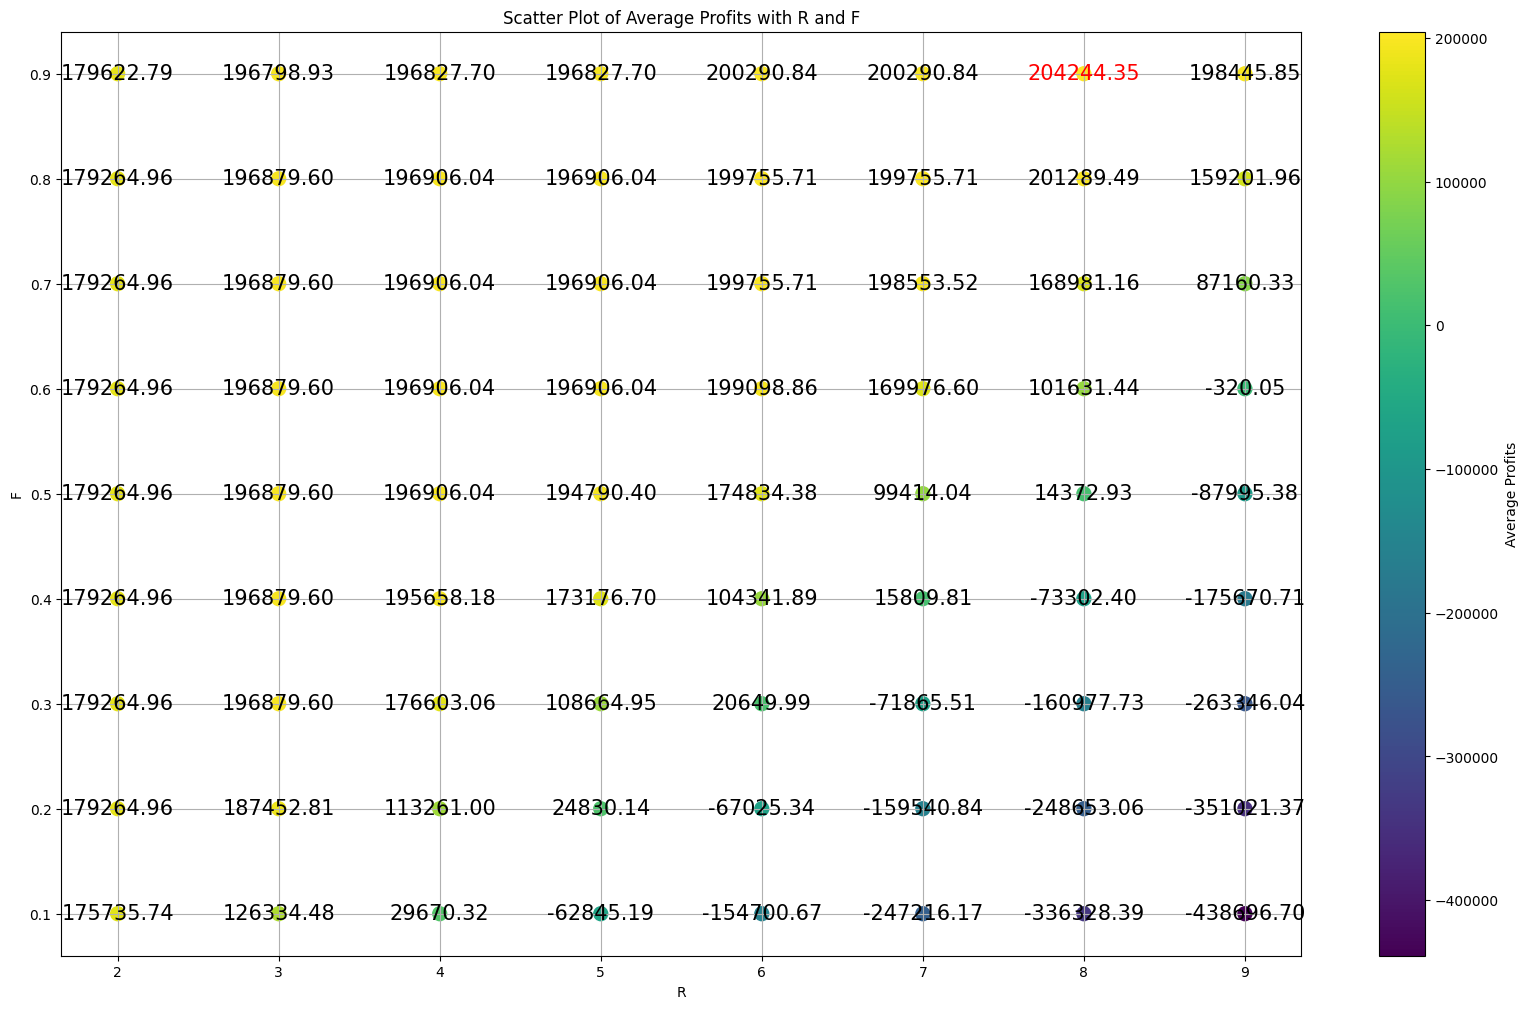

In [4233]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_med_with_holding_cost_20_100_202502052119.png


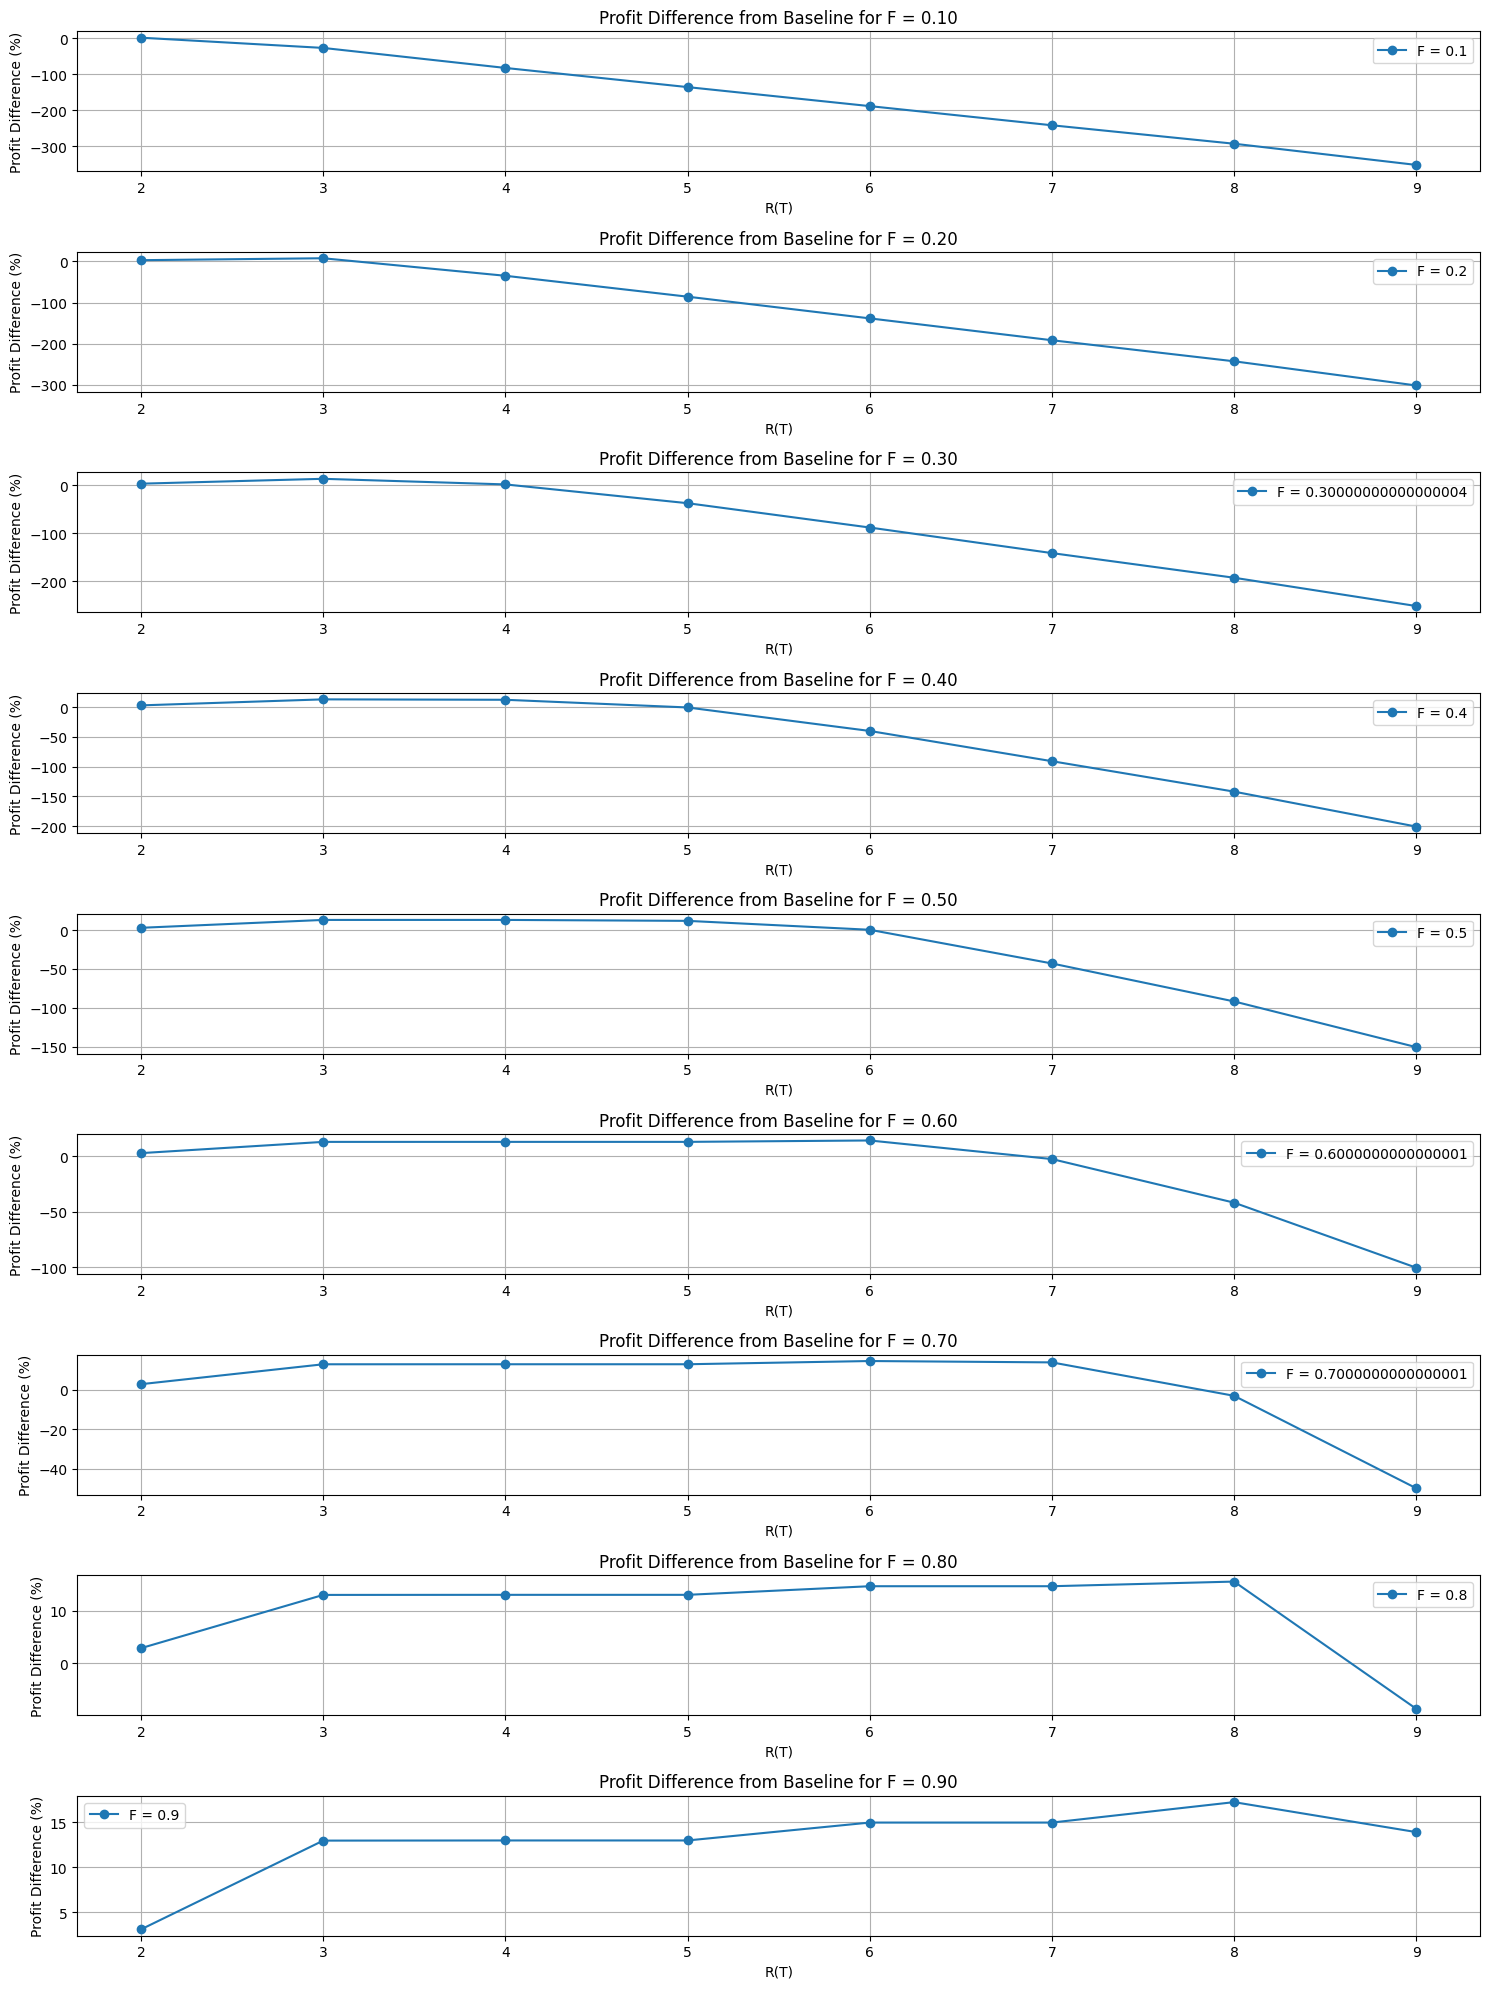

In [4234]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [4235]:
results_df_8, stimulation_results_df_8 = None, None

# results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#     assigned_Ts=ASSIGNED_TS,
#     assigned_Fs=ASSIGNED_FS,
#     cost=cost,
#     price=price,
#     salvage_value=salvage_value,
#     Qk_hat_df=Qk_hat_df_train,
#     demand_df_train=demand_df_train,
#     Q_star=Q_star,
#     holding_cost=holding_cost,
# )
# results_df_8

In [4236]:
stimulation_results_df_8

In [4237]:
# # 比較結果
# max_profit = results_df_8["average_profits"].max()

# print("\n============ Below is the comparison results =================")
# print(f"Q_star: {Q_star}")
# print(f"Maximum Profit: {max_profit}")

In [4238]:
# # 找出 average_profits 前三名的資料
# top_three_results = results_df_8.head(3)

# # 提取 R (T), F 和 average_profits
# top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
# top_three_info

In [4239]:
# # 找到 'average_profits' 的最大值
# max_profit = results_df_8["average_profits"].max()

# # 画出散点图
# plt.figure(figsize=(20, 12))
# sc = plt.scatter(
#     results_df_8["R(T)"],
#     results_df_8["F"],
#     c=results_df_8["average_profits"],
#     cmap="viridis",
#     s=100,
# )
# plt.colorbar(label="Average Profits")
# plt.xlabel("R")
# plt.ylabel("F")
# plt.title("Scatter Plot of Average Profits with R and F")
# plt.grid(True)

# # 在每个数据点上标注数值
# for i in range(len(results_df_8)):
#     avg_profit = results_df_8["average_profits"].iloc[i]
#     # 判断是否等于 max_profit 的整數部分
#     if int(avg_profit) == int(max_profit):
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="red",
#         )
#     else:
#         plt.text(
#             results_df_8["R(T)"].iloc[i],
#             results_df_8["F"].iloc[i],
#             f"{avg_profit:.2f}",
#             fontsize=15,
#             ha="center",
#             va="center",
#             color="black",
#         )

# name = "grid_fixed_F_fixed_R_metrics_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

In [4240]:
# results_df_8["baseline_profit"] = baseline_avg_profits

# # Calculate percentage difference from baseline profit
# results_df_8["profit_diff_percent"] = (
#     (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
# ) * 100

# # Plot subplots for different values of F
# plt.figure(figsize=(15, 20))

# for idx, F in enumerate(ASSIGNED_FS):
#     plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
#     subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
#     plt.plot(
#         subset["R(T)"],
#         subset["profit_diff_percent"],
#         marker="o",
#         linestyle="-",
#         label=f"F = {F}",
#     )
#     plt.xlabel("R(T)")
#     plt.ylabel("Profit Difference (%)")
#     plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
#     plt.grid(True)
#     plt.legend()

# plt.tight_layout()

# name = "grid_fixed_F_fixed_R_trend_s8"

# os.makedirs("plots", exist_ok=True)
# save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

# plt.savefig(save_path, format="png", bbox_inches="tight")
# print(f"Plot saved as {save_path}")

# # Show plot
# plt.show()
# plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [4241]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2, best_R_F_per_demand = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 8000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 500 rows, 705 columns and 1450 nonzeros
Model fingerprint: 0x1e963ed3
Model has 300 general constraints
Variable types: 705 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+03]
  RHS range        [1e+00, 8e+03]
  GenCon const rng [2e+02, 8e+03]
Presolve added 53 rows and 303 columns
Presolve time: 0.01s
Presolved: 553 rows, 1008 columns, 2862 nonzeros
Presolved model has 50 SOS c

In [4242]:
print(f"Feasible R: {results_df_2['R(T)'].unique()}")
results_df_2

Feasible R: [9 8 7 6 5 4 3 2]


R(T)                                                  R  average_profits  \
7     9  [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...    212212.411303   
6     8  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...    205576.459603   
5     7  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...    201694.631898   
4     6  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...    201593.733513   
3     5  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...    199294.102547   
2     4  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...    199211.838487   
1     3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...    198801.022076   
0     2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    182981.074202   

   average_losses  average_lefts  average_operation_profits  \
7        5.112347      12.882282              213267.541407   
6       93.008061      32.342408              210630.669976   
5      129.091364      56.868543              209548.170873   
4      120.278410      65.863910              209812.559495   
3      173.012921      53.514771              208230.524176   
2      174.315507      53.573470              208191.446608   
1      178.861671      55.545564              208055.061671   
0      371.209764     116.675025              202284.618876   

                                        alpha_values  \
7  [-0.5548908896126736, -0.11059292712914855, 1....   
6  [0.6232328303212777, -0.05956712871445562, 1.1...   
5  [-0.2519926751507072, 0.09248075304286359, 2.0...   
4  [-2.1284808569147295, -1.0460871521249577, 4.7...   
3  [0.16447676663851193, 0.5009527687809333, 0.88...   
2  [0.08818242138494174, 0.37422071859456524, 0.7...   
1  [2.02468110474282, 0.1876034029880275, 1.12409...   
0  [-1.7865108433128871, -1.1120614301313303, 1.9...   

                                              F_vars  \
7  [0.7233219658785659, 0.9535655070260999, 0.920...   
6  [0.8977304929240982, 0.899027975328498, 0.9147...   
5  [0.8813130626284651, 0.99752330768093, 0.88800...   
4  [0.9145740728881924, 0.9983240558649048, 0.931...   
3  [0.9093706713627798, 0.5, 0.9107351643965796, ...   
2  [0.8912870491178831, 0.5, 0.8991737947633524, ...   
1  [0.9159690417274706, 0.5, 0.9147303005259628, ...   
0  [0.999557698840686, 0.998324055864905, 0.91473...   

                                             Q0_vars  \
7  [4878.2685488197, 6431.089945560547, 6205.5072...   
6  [6054.524313565863, 6063.274867129299, 6169.17...   
5  [5943.80095987046, 6727.552608835651, 5988.943...   
4  [6168.1217297435505, 6732.9530596247605, 6283....   
3  [6133.028657493948, 3372.1320858740937, 6142.2...   
2  [6011.068078654253, 3372.132468480511, 6064.25...   
1  [6177.529756785794, 3372.128028003703, 6169.17...   
0  [6741.273063735123, 6732.953059624761, 6169.17...   

                                             Q1_vars  
7  [1254.7601086742397, 301.86311406421464, 0.0, ...  
6  [0.0, 741.9112038967123, 0.0, 1937.88463816147...  
5  [432.9395536678033, 0.0, 0.0, 0.0, 910.9923831...  
4  [208.6187819401148, 0.0, 0.0, 0.0, 896.5780951...  
3  [0.0, 3000.5999739265108, 0.0, 0.0, 4464.92107...  
2  [101.38479542104596, 3000.5995905172845, 0.0, ...  
1  [0.0, 3006.246760128883, 0.0, 0.0, 1102.488939...  
0  [0.0, 0.0, 0.0, 0.0, 462.29450306754916, 0.0, ...

In [4243]:
stimulation_results_df_2

R         F        profits      losses       lefts  operation_profits  \
0   7  0.723322  183990.859725    0.000000    0.000000      183990.859725   
1   7  0.953566  201988.591789    0.000000    0.000000      201988.591789   
2   7  0.920117  182532.028117    0.000000   36.331899      185075.261068   
3   7  0.880797  204684.605360    0.000000   -0.000002      204684.605249   
4   7  0.997527  237821.284503    0.000000    0.000000      237821.284465   
5   7  0.954481  181813.572199    0.000000  113.043804      189726.638489   
6   7  0.922432  196192.068534    0.000000    0.000000      196192.068534   
7   7  0.957544  195244.393822    0.000000    0.000000      195244.393822   
8   7  0.997527  231881.109011    0.000000   -0.000003      231881.108812   
9   7  0.999662  239807.574046   76.356456   76.356454      247443.219483   
10  7  0.999664  232217.582474  179.260870  179.260870      250143.669467   
11  7  0.863120  202892.419699    0.000000   -0.000001      202892.419598   
12  7  0.880797  194452.384024    0.000000    0.000000      194452.384024   
13  7  0.996318  219905.513197    0.000000   -0.000002      219905.513090   
14  7  0.997527  237721.604589    0.000000   -0.000002      237721.604444   
15  7  0.896160  196321.487342    0.000000    0.000000      196321.487285   
16  7  0.991754  210742.699513    0.000000   -0.000002      210742.699382   
17  7  0.928712  184651.406135    0.000000   32.527693      186928.344666   
18  7  0.880797  178371.680286    0.000000    0.000000      178371.680254   
19  7  0.987707  204602.398564    0.000000    0.000000      204602.398567   
20  7  0.982014  231859.088384    0.000000   -0.000002      231859.088252   
21  7  0.997903  201455.904395    0.000000    4.474679      201769.131926   
22  7  0.982770  195533.061176    0.000000   33.084342      197848.965087   
23  7  0.999665  224881.859247    0.000000   -0.000002      224881.859138   
24  7  0.947533  239387.197368    0.000000   -0.000001      239387.197290   
25  7  0.991077  226463.600264    0.000000   -0.000003      226463.600078   
26  7  0.999661  205334.188813    0.000000   -0.000003      205334.188620   
27  7  0.754455  194782.959314    0.000000    0.000000      194782.959314   
28  7  0.880797  198445.968777    0.000000    0.000000      198445.968777   
29  7  0.997527  236726.429039    0.000000   -0.000003      236726.428860   
30  7  0.997527  239533.721363    0.000000    0.000000      239533.721301   
31  7  0.880797  202608.171096    0.000000   -0.000002      202608.170923   
32  7  0.982014  219394.321389    0.000000    0.000000      219394.321371   
33  7  0.982014  220474.069838    0.000000    0.000001      220474.069943   
34  7  0.982014  223746.552289    0.000000   -0.000003      223746.552109   
35  7  0.982014  230426.015210    0.000000   -0.000001      230426.015105   
36  7  0.992472  248347.754434    0.000000   -0.000002      248347.754323   
37  7  0.995409  216306.999828    0.000000   -0.000002      216306.999716   
38  7  0.983127  212879.334762    0.000000   -0.000002      212879.334641   
39  7  0.997527  247874.176978    0.000000   -0.000003      247874.176741   
40  7  0.993178  217268.385849    0.000000    0.000000      217268.385813   
41  7  0.965526  183687.600399    0.000000  116.651023      191853.172003   
42  7  0.997527  223230.386657    0.000000   -0.000002      223230.386517   
43  7  0.699585  177704.179967    0.000000    0.000000      177704.179967   
44  7  0.882675  225349.583117    0.000000   -0.000001      225349.583036   
45  7  0.880797  172971.294579    0.000000   52.383362      176638.129946   
46  7  0.997476  244854.026267    0.000000    0.000000      244854.026219   
47  7  0.994964  205021.201729    0.000000   -0.000002      205021.201558   
48  7  0.942382  198145.420942    0.000000    0.000000      198145.420942   
49  7  0.991255  228091.848759    0.000000   -0.000002      228091.848619   

             Q0           Q1  
0   4878.268549  1254.760109  
1   6431.08994

In [4244]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    stimulation_results_df_2["Qk_hat"] = Qk_hat_df_train.iloc[
        :, stimulation_results_df_2.iloc[0, 0]
    ]
    stimulation_results_df_2["Qk_hat-Q0"] = (
        stimulation_results_df_2["Qk_hat"] - stimulation_results_df_2["Q0"]
    )
    stimulation_results_df_2["Q_star"] = Q_star
    stimulation_results_df_2[["R", "F", "Q_star", "Q0", "Qk_hat", "Qk_hat-Q0", "Q1"]]

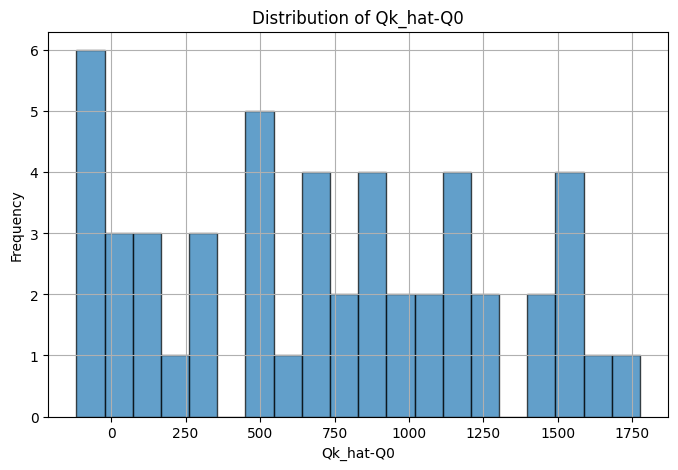

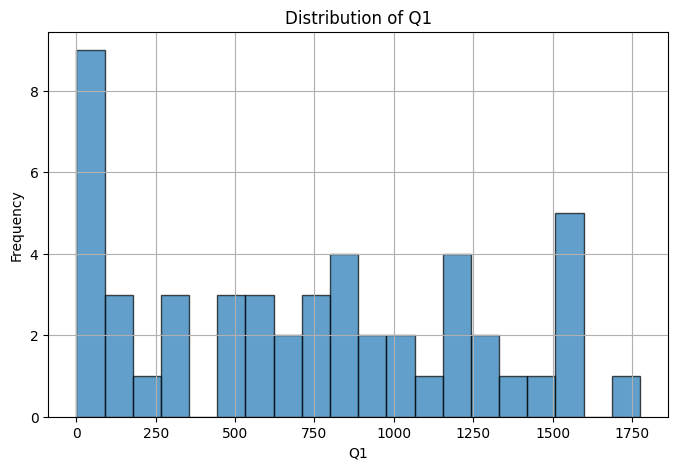

In [4245]:
if stimulation_results_df_2 is not None and len(stimulation_results_df_2) > 0:
    # Plotting the distribution of "Qk_hat-Q0"
    plt.figure(figsize=(8, 5))
    plt.hist(
        stimulation_results_df_2["Qk_hat-Q0"], bins=20, alpha=0.7, edgecolor="black"
    )
    plt.title("Distribution of Qk_hat-Q0")
    plt.xlabel("Qk_hat-Q0")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Plotting the distribution of "Q1"
    plt.figure(figsize=(8, 5))
    plt.hist(stimulation_results_df_2["Q1"], bins=20, alpha=0.7, edgecolor="black")
    plt.title("Distribution of Q1")
    plt.xlabel("Q1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [4246]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

Model parameters saved as models/med_with_holding_cost_20_s2_100_202502052119.pkl


In [4247]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

R(T)  average_profits
7     9    212212.411303
6     8    205576.459603
5     7    201694.631898

### S3 - Grid for Fixed F & Flexible Rk


In [4248]:
results_df_3, stimulation_results_df_3 = None, None
# results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )

# results_df_3 = grid_fixed_F_flexible_R(
#     assigned_Fs=ASSIGNED_FS,
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df_train=Qk_hat_df_train,
#     training_df=training_df,
# )


# results_df_3

In [4249]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [4250]:
stimulation_results_df_3

In [4251]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [4252]:
results_df_5, stimulation_results_df_5 = None, None
# results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_5

In [4253]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [4254]:
stimulation_results_df_5

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [4255]:
results_df_6, stimulation_results_df_6 = None, None
# results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
results_df_6

In [4256]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

In [4257]:
stimulation_results_df_6

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [4258]:
results_df_7, stimulation_results_df_7 = None, None
# results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_7

In [4259]:
if results_df_7 is not None:
    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [4260]:
stimulation_results_df_7

#### S4 - Beta with softmax


In [4261]:
results_df_4, stimulation_results_df_4 = None, None
# results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
#     salvage_value=salvage_value,
#     cost=cost,
#     price=price,
#     Q_star=Q_star,
#     demand_df_train=demand_df_train,
#     Qk_hat_df=Qk_hat_df_train,
#     training_df=training_df,
# )
# results_df_4

In [4262]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

### S10 - ML Model

1. grid 得到每一筆資料的最佳 R
2. 訓練 ml model
3. 將 ml 利用在 gurobi 模型中

In [4263]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (50, 8)


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0  6967.128557  7392.270487  7408.454946  7408.454944  7391.239479   
1  6355.262041  7662.776191  7684.841882  7684.841894  7703.660129   
2  6762.467064  6677.897751  6590.982107  6590.982115  6640.034596   
3  6228.991752  5827.384203  5845.210796  5845.210788  5798.343220   
4  6139.436343  7489.373313  7460.018583  7460.018581  7265.903083   

     Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0  7391.239479  7222.549229  7538.982816  
1  7703.660130  7812.623710  7969.545251  
2  6640.034597  6726.993677  6455.499692  
3  5798.343216  5790.160365  5805.042782  
4  7265.903084  7375.669517  7798.855928

In [4264]:
results_df_2_test, stimulation_results_df_2_test = None, None
results_df_2_test, stimulation_results_df_2_test, best_R_F_per_demand_test = (
    grid_flexible_F_fixed_R(
        assigned_Ts=ASSIGNED_TS,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_test,
        Qk_hat_df_train=Qk_hat_df_test,
        training_df=testing_df,
    )
)

+++++++++++++++++++++++++++++++++++++++ THis is R=0 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 8000
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 500 rows, 705 columns and 1450 nonzeros
Model fingerprint: 0x2a7081ab
Model has 300 general constraints
Variable types: 705 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 7e+03]
  RHS range        [1e+00, 8e+03]
  GenCon const rng [2e+02, 8e+03]
Presolve added 96 rows and 346 columns
Presolve time: 0.01s
Presolved: 596 rows, 1051 columns, 2988 nonzeros
Presolved model has 50 SOS c

In [4265]:
print(f"Unique R of test data: {best_R_F_per_demand_test['best_R'].unique()}")

Unique R of test data: [7 6 2 5 1 4]


In [4266]:
print(f"best_R_F_per_demand_test.shape: {best_R_F_per_demand_test.shape}")
best_R_F_per_demand_test.head()

best_R_F_per_demand_test.shape: (50, 4)


index  best_R    best_F    best_profit
0      0       7  0.982014  226169.484565
1      1       7  0.945518  239086.357588
2      2       7  0.957185  193664.990793
3      3       6  0.860739  174151.283413
4      4       7  0.922137  233965.677902

2. 訓練 ml model

In [4267]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)

# 準備輸入特徵 (X) 與分類標籤 (y)
X = training_df  # 訓練特徵
y = best_R_F_per_demand["best_R"]  # 目標類別標籤

# 檢查 y 是否包含完整的 0~7 類別
unique_classes = np.unique(y)
print(f"訓練標籤的類別: {unique_classes}")

# 確保所有類別都存在
expected_classes = set(range(8))
if set(unique_classes) != expected_classes:
    print("⚠️ 訓練資料缺少部分類別！")
else:
    print("✅ 訓練資料包含完整的 0~7 類別。")

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 定義模型與超參數
models = {
    "Logistic Regression": {
        "model": LogisticRegression(
            multi_class="multinomial", solver="lbfgs", max_iter=3000
        ),
        "params": {"C": [0.01, 0.1, 1, 10, 25, 50, 100]},
    },
    "SVM": {
        "model": SVC(),
        "params": {"C": [0.01, 0.1, 1, 10, 25], "kernel": ["linear", "rbf"]},
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, 20],
            "criterion": ["gini", "entropy"],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10],
            "learning_rate": [0.01, 0.1, 0.3],
        },
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10],
            "learning_rate": [0.01, 0.1, 0.3],
        },
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 10],
            "learning_rate": [0.01, 0.1, 0.3],
        },
    },
}

best_model = None
best_score = -1
best_params = None
best_model_name = ""

# 迭代測試每個模型
for name, model_info in models.items():
    print(f"\n正在測試模型: {name}")

    grid_search = GridSearchCV(
        model_info["model"],
        model_info["params"],
        cv=5,  # 5-fold 交叉驗證
        scoring="f1_macro",  # 使用 f1_macro 來評估多分類準確性
        n_jobs=-1,
    )

    grid_search.fit(X, y)

    print(f"{name} 最佳參數: {grid_search.best_params_}")
    print(f"{name} 最佳 F1 分數: {grid_search.best_score_:.4f}")

    # 儲存最佳模型
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_model_name = name

print("\n✅ 最佳模型: ", best_model_name)
print("✅ 最佳模型參數: ", best_params)
print("✅ 最佳模型 F1 分數: ", best_score)

# 訓練最佳模型
best_model.fit(X, y)
model = best_model

# # 輸出模型的係數
# coefficients = model.coef_
# intercept = model.intercept_

# 計算訓練準確度
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)

# 顯示結果
print("\n模型訓練完成")
print(f"分類準確度 (Accuracy): {accuracy:.4f}")
print(f"f1_score: {f1_score(y, y_pred, average='weighted')}")


test_y_pred = model.predict(testing_df)
test_accuracy = accuracy_score(best_R_F_per_demand_test["best_R"], test_y_pred)
print(f"測試準確度 (Accuracy): {test_accuracy:.4f}")
print(
    f"測試 f1_score: {f1_score(best_R_F_per_demand_test['best_R'], test_y_pred, average='weighted')}"
)

# # 顯示結果
# print(f"\n截距 (Intercept): {intercept}")
# print("特徵係數 (Coefficients):")
# for feature, coef in zip(X.columns, coefficients.T):  # 轉置以對應特徵
#     print(f"{feature}: {coef}")

# 儲存訓練好的模型與標準化工具
joblib.dump(model, "logistic_regression_best_R.pkl")
print("模型已儲存為 'logistic_regression_best_R.pkl'")

訓練標籤的類別: [0 1 3 4 6 7]
⚠️ 訓練資料缺少部分類別！

正在測試模型: Logistic Regression
Logistic Regression 最佳參數: {'C': 0.01}
Logistic Regression 最佳 F1 分數: 0.2420

正在測試模型: SVM
SVM 最佳參數: {'C': 10, 'kernel': 'rbf'}
SVM 最佳 F1 分數: 0.2700

正在測試模型: Random Forest


/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureW

Random Forest 最佳參數: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 50}
Random Forest 最佳 F1 分數: 0.2139

正在測試模型: XGBoost


/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/hanyuan/Github/Two-Phase-Newsvendor/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5], got [0 1 3 4 6 7]


In [3552]:
#     f"測試 f1_score: {f1_score(best_R_F_per_demand_test['best_R'], test_y_pred, average='weighted')}"
# )

# # # 顯示結果
# # print(f"\n截距 (Intercept): {intercept}")
# # print("特徵係數 (Coefficients):")
# # for feature, coef in zip(X.columns, coefficients.T):  # 轉置以對應特徵
# #     print(f"{feature}: {coef}")

# # 儲存訓練好的模型與標準化工具
# joblib.dump(model, "logistic_regression_best_R.pkl")

# print("模型已儲存為 'logistic_regression_best_R.pkl'")

In [3553]:
# # 讀取模型
# logistic_model = joblib.load("logistic_regression_best_R.pkl")

# # 取得 logistic regression 的參數
# intercept = logistic_model.intercept_  # 這是 shape (K,)
# coefficients = logistic_model.coef_  # 這是 shape (K, features_num)

# for feature, coef in zip(X.columns, coefficients.T):  # 轉置以對應特徵
#     print(f"{feature}: {coef}")
# print(f"intercept: \n{intercept}")

# betas_values = np.vstack([coefficients.T, intercept])  # (features_num + 1, K)
# betas_values = betas_values.T
# print(f"\nbetas_values.shape: {betas_values.shape}")
# betas_values

3. 將訓練好的 model 融入 gurobi

In [3554]:
results_df_10, stimulation_results_df_10 = None, None
results_df_10, stimulation_results_df_10 = fully_flexible_beta_with_softmax_10(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_10

Set parameter Threads to value 12
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 8000
Set parameter IntFeasTol to value 1e-09
Predicted R Categories: [7 5 7 0 5 7 3 7 7 7 6 7 7 0 7 5 7 7 7 7 7 7 7 7 4 1 7 7 7 7 3 0 7 7 0 7 6
 0 7 3 6 0 7 4 7 7 7 7 7 7]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 450 rows, 855 columns and 1450 nonzeros
Model fingerprint: 0xad9ce324
Model has 400 general constraints
Variable types: 855 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-02, 4e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+02, 5e+03]
  GenCon const rng [1e+02, 4e+03]
Presolve added 69 rows and 119 columns
Presolve time: 0.01s
Presolved: 5

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/4052732949.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Q_hat = Qk_hat_df_row[assigned_R]


average_profits  average_losses  average_lefts  average_operation_profits  \
0    224462.202942        8.979529     778.973307              225618.131284   

                                        alpha_values beta_values tau_values  
0  [-0.005802241920913245, -0.00916783195990458, ...        None       None

In [3555]:
if results_df_10 is not None:
    save_model_parameters(
        f"{model_prefix}_s10",
        alpha_values=results_df_10.iloc[0]["alpha_values"],
        beta_values=results_df_10.iloc[0]["beta_values"],
        tau_values=results_df_10.iloc[0]["tau_values"],
        f_values=stimulation_results_df_10["f_values"].values,
    )

Model parameters saved as models/med_with_holding_cost_20_s10_100_202502052115.pkl


### Analysis


#### Baseline


In [3556]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 168200.6904052135


#### S1


In [3557]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
11     3  0.3  [1151.1499833384105, 1151.1499833384105, 1151....   
12     3  0.4  [1534.866644451214, 1534.866644451214, 1534.86...   
22     4  0.5  [1918.5833055640173, 1918.5833055640173, 1918....   
13     3  0.5  [1918.5833055640173, 1918.5833055640173, 1918....   
21     4  0.4  [1534.866644451214, 1534.866644451214, 1534.86...   
..   ...  ...                                                ...   
55     8  0.2  [767.433322225607, 767.433322225607, 767.43332...   
45     7  0.1  [383.7166611128035, 383.7166611128035, 383.716...   
64     9  0.2  [767.433322225607, 767.433322225607, 767.43332...   
54     8  0.1  [383.7166611128035, 383.7166611128035, 383.716...   
63     9  0.1  [383.7166611128035, 383.7166611128035, 383.716...   

                                                   Q1  average_profits  \
11  [385.2025832696827, 1041.64629651436, 1099.979...    221824.688965   
12  [1.485922156879269, 657.9296354015567, 716.263...    221309.336240   
22  [0, 272.97988022822256, 329.75456997967103, 0,...    220506.681878   
13  [0, 274.21297428875323, 332.5463422210878, 0, ...    220501.128205   
21  [3.902275751407842, 656.696541341026, 713.4712...    220493.548274   
..                                                ...              ...   
55  [671.2104147161266, 1383.0196164352833, 1429.2...    -27139.565113   
45  [1084.843554819737, 1758.6415478917768, 1908.5...    -39984.828043   
64  [672.6861374864706, 1385.306001112985, 1401.49...    -82822.318734   
54  [1054.9270758289301, 1766.7362775480867, 1812....    -92216.937771   
63  [1056.402798599274, 1769.0226622257885, 1785.2...   -148054.151123   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
11       17.403552      66.183734              225028.449653    168200.690405   
12       17.403552      83.362159              225028.449653    168200.690405   
22       15.007723     121.297839              225196.157681    168200.690405   
13       15.042004     121.322984              225193.758016    168200.690405   
21       22.193103      88.203854              224693.181105    168200.690405   
..             ...            ...                        ...              ...   
55     1485.589954    1513.455663              122255.401544    168200.690405   
45     1558.711686    1600.396345              117136.880309    168200.690405   
64     1818.031377    1818.154141               98984.501898    168200.690405   
54     1868.398028    1896.263738               95458.836332    168200.690405   
63     2201.748038    2201.870802               72124.335620    168200.690405   

    profit_diff_percent  
11            31.880962  
12            31.574571  
22            31.097370  
13            31.094068  
21            31.089562  
..                  ...  
55          -116.135228  
45          -123.772095  
64          -149.240178  
54          -154.825541  
63          -188.022321  

[72 rows x 10 columns]

In [3558]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：156882.0923659637
策略1最佳策略在：R=3, F=0.30000000000000004
策略1最佳策略之下最大利潤為：221824.68896539338


#### S2


In [3559]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

策略2平均利潤為：221138.54414514688
策略2最佳策略在：R=7, F為彈性
策略2最佳策略之下最大利潤為：223504.86901446767


#### S3


In [3560]:
# 策略三
results_df_3

In [3561]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [3562]:
results_df_4

In [3563]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    # print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [3564]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [3565]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

Model didn't find optimized result.


#### S7


In [3566]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [3567]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = stimulation_results_df_8.loc[
        stimulation_results_df_8["profits"].idxmax()
    ]
    max_profit_for_s8 = max_profit_row["profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

Model didn't find optimized result.


S10

In [3568]:
if results_df_10 is None or len(results_df_10) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s10 = -1
else:
    max_profit_row = results_df_10.loc[results_df_10["average_profits"].idxmax()]
    max_profit_for_s10 = max_profit_row["average_profits"]

    # print(f"策略10最佳策略在：\nR為彈性, F={max_profit_row['F'][0]}")
    print(f"策略10最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s10}")

策略10最佳策略之下最大利潤(Avg profit)為：224462.20294163137


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_med_with_holding_cost_20_100_202502052115.png


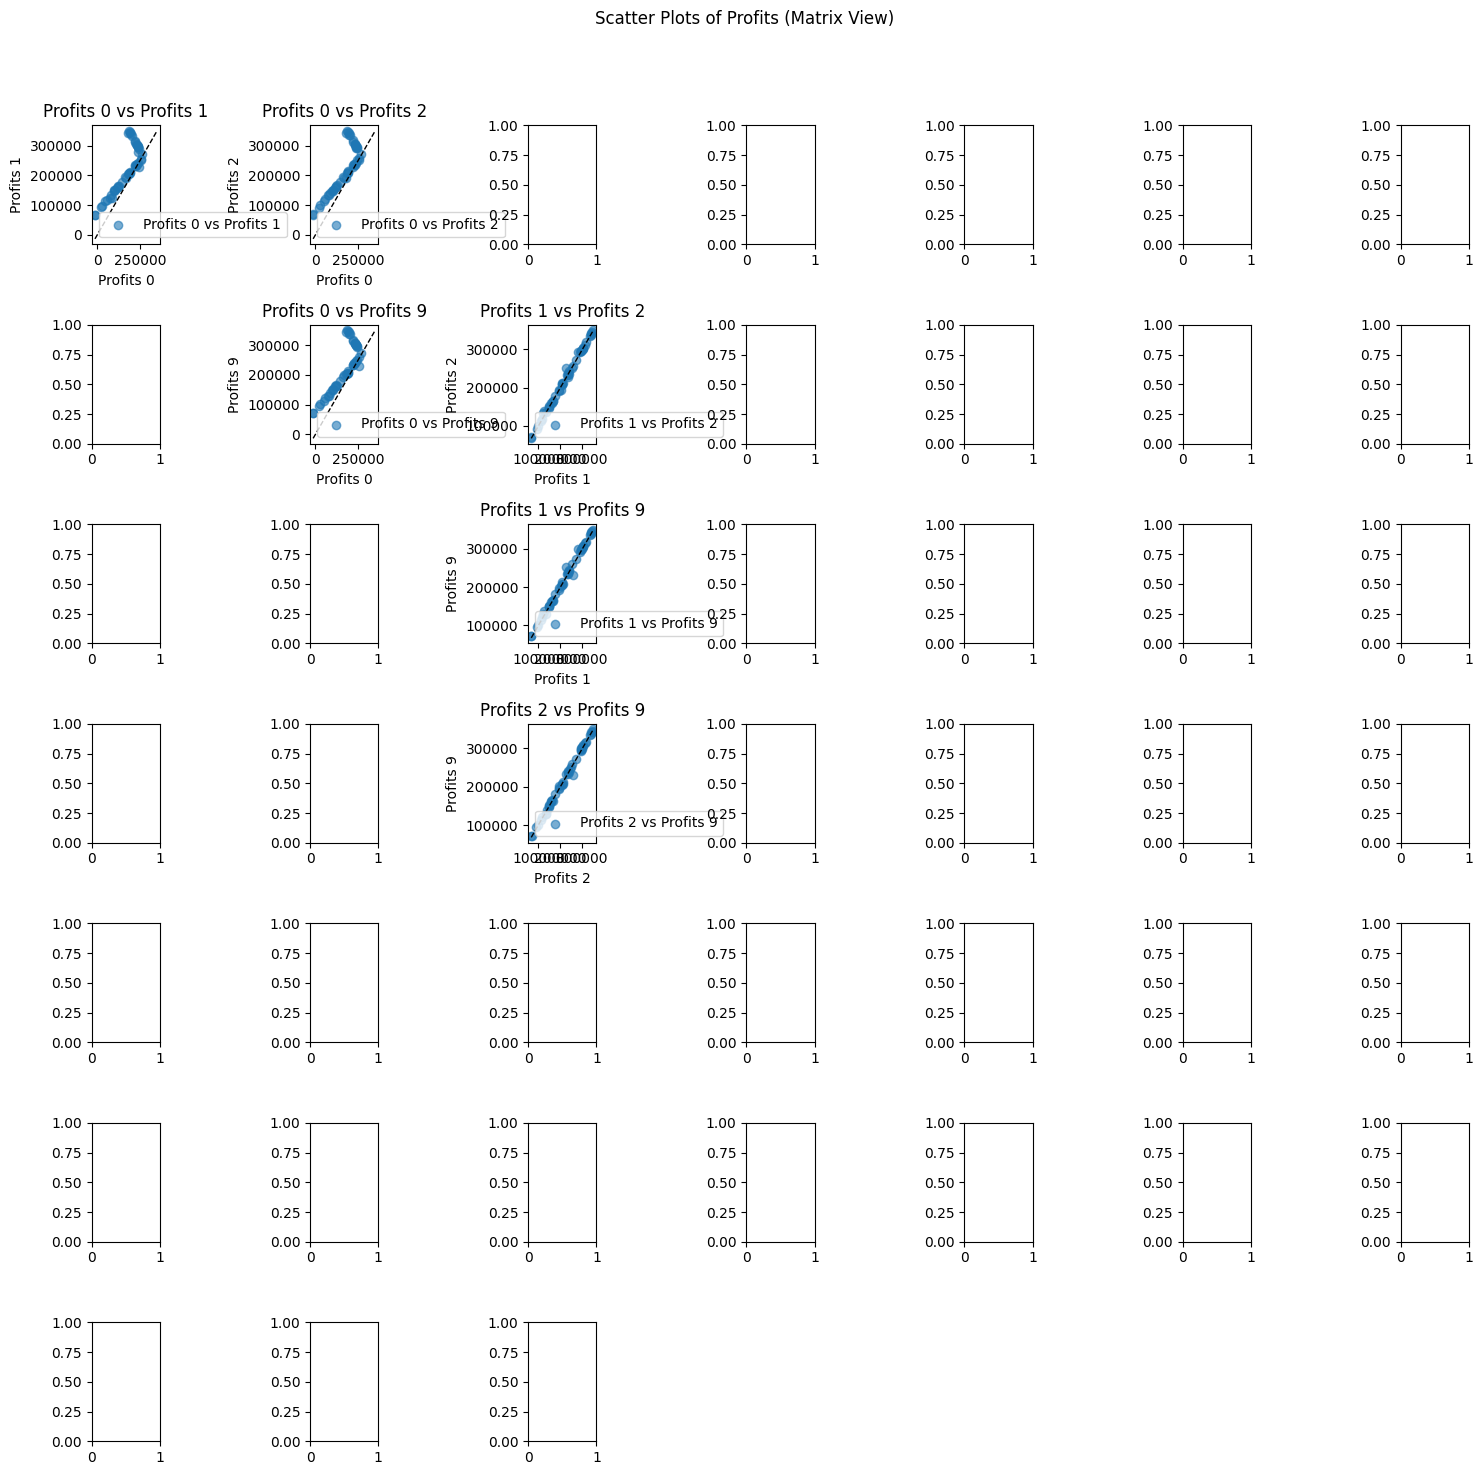

In [ ]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
    stimulation_results_df_10,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_100_S1_202502052115.png


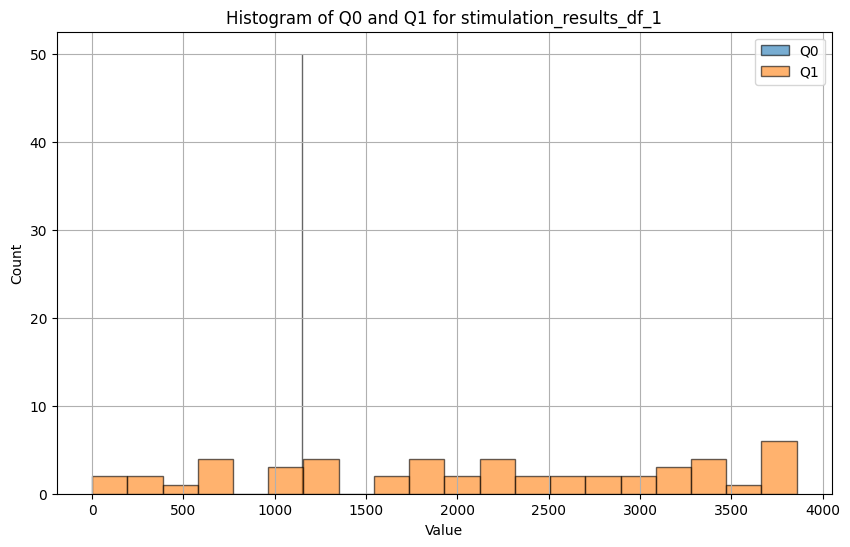

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_100_S2_202502052115.png


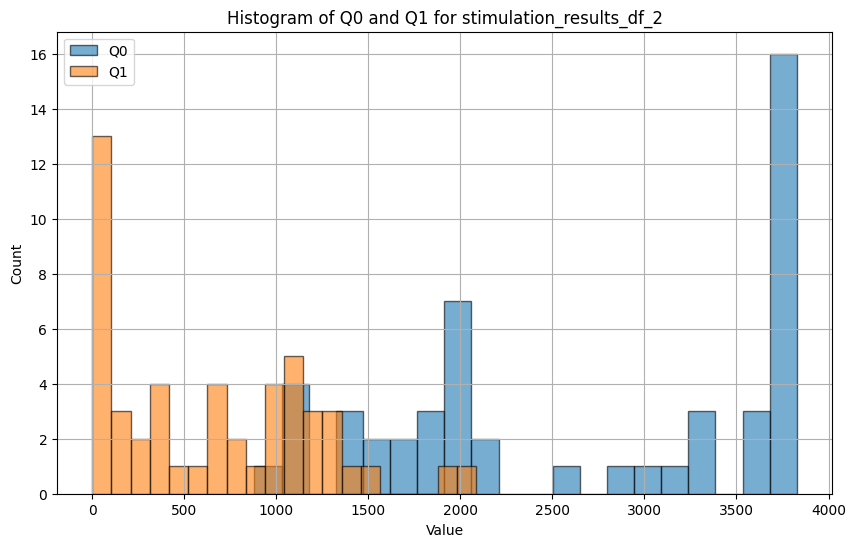

Plot saved as plots/plot_Q0_Q1_distribution_train_med_with_holding_cost_20_100_S9_202502052115.png


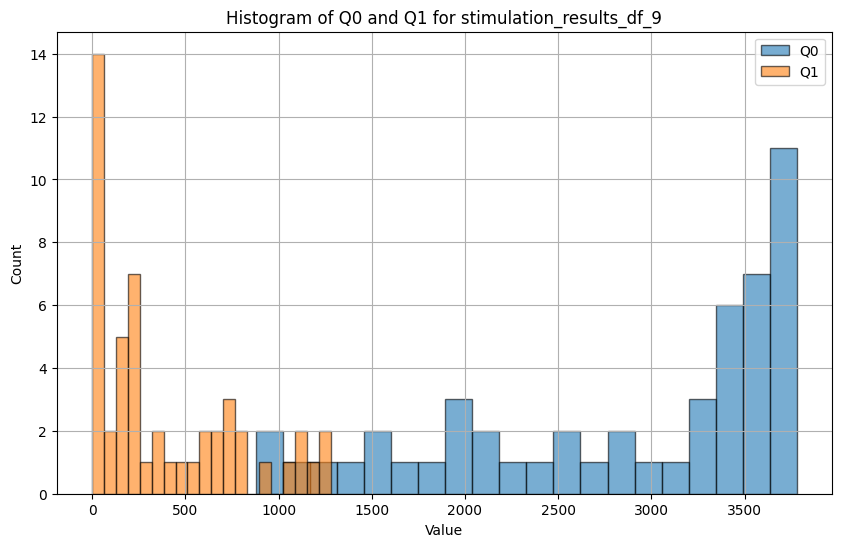

In [ ]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_100_S1_202502052115.png


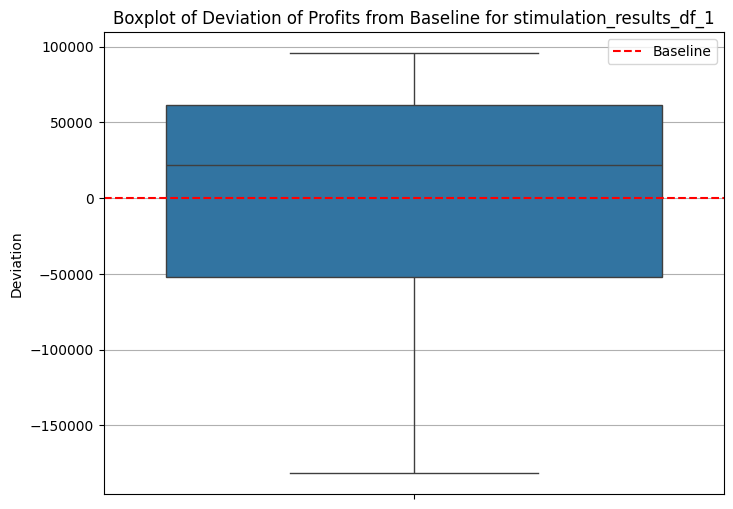

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_100_S2_202502052115.png


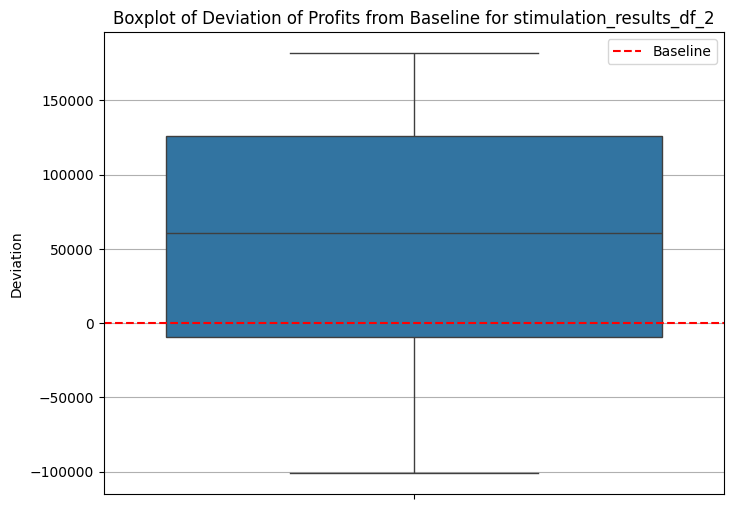

Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_100_S3_202502052115.png


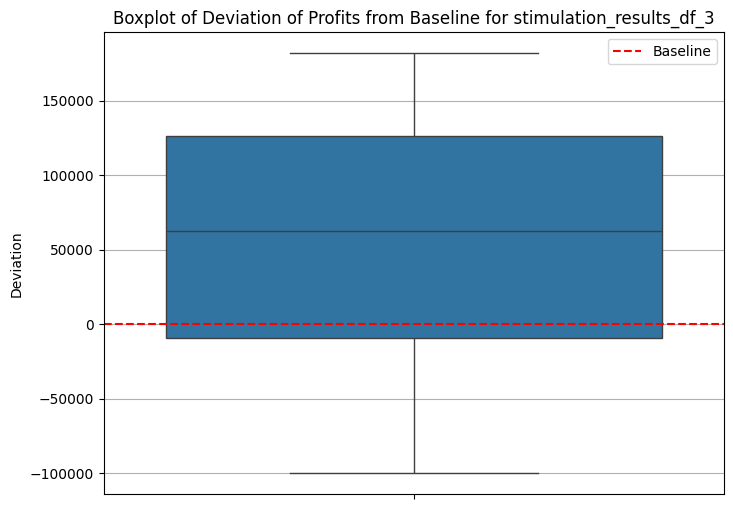

Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Skipping stimulation_results_df_9: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_med_with_holding_cost_20_100_S10_202502052115.png


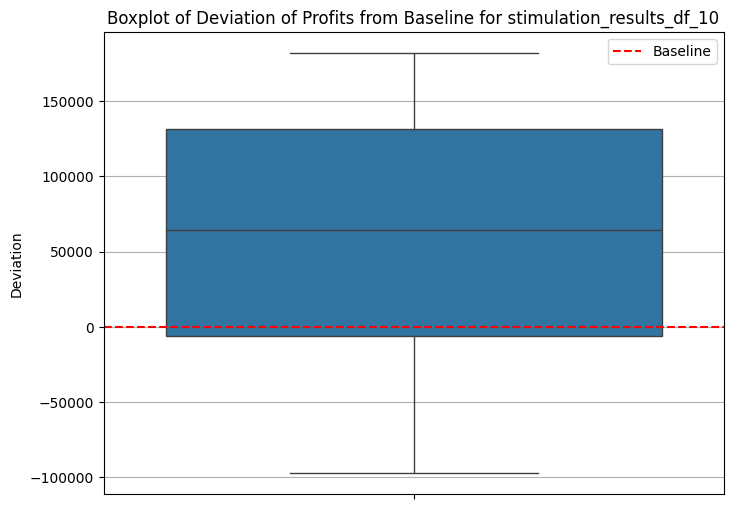

In [ ]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 168200.6904052135
S1's profit: 221824.68896539338
S2's profit: 223504.86901446767
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
S9's profit: 224462.20294163137
Plot saved as plots/plot_relative_profit_deviation_train_med_with_holding_cost_20_100_202502052115.png


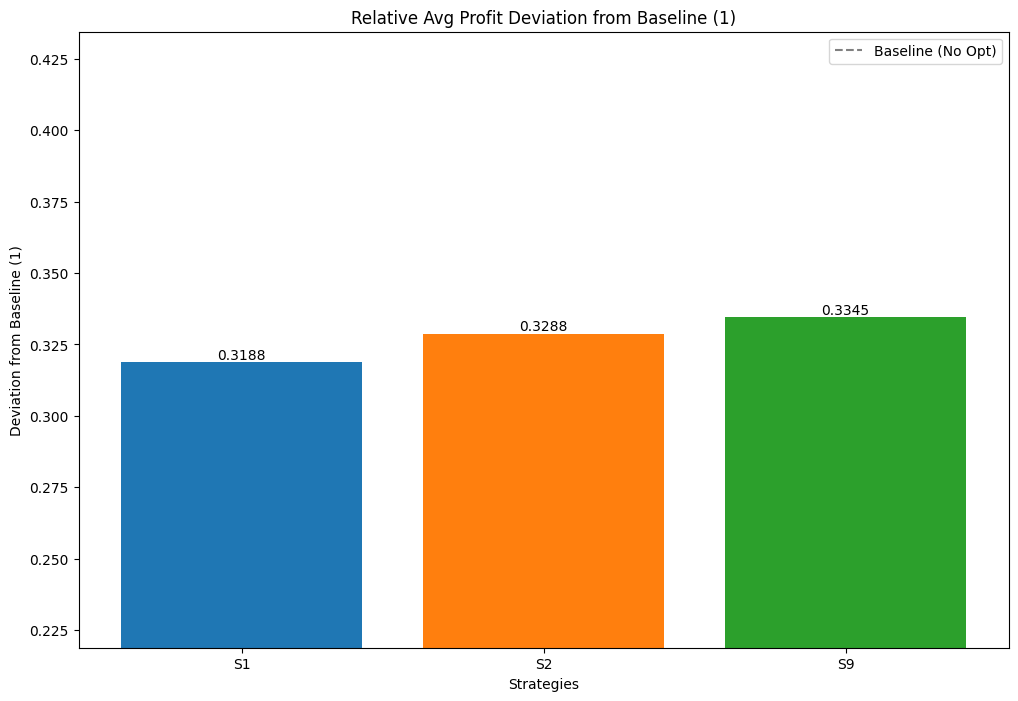

In [ ]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
    max_profit_for_s10,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [3573]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [3574]:
status = "test"

In [3575]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 3232.0956901021073
std of sum: 1153.8335801795834
70.0 percentile of sum: 3837.1666111280347
Q_star: 3837.1666111280347


In [3576]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (50, 8)


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/3639980328.py:8: RuntimeWarning: invalid value encountered in sqrt
  sd_Y = np.sqrt(var_Y)
/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787

Qk_hat_k2    Qk_hat_k3    Qk_hat_k4    Qk_hat_k5    Qk_hat_k6  \
0  4527.118820  3834.951355  3832.957479  3832.251585  3832.899085   
1  4319.858183  4940.035588  4932.889020  4936.805311  4977.030378   
2  3743.822088  2607.354264  2602.780278  2596.639235  2425.651162   
3  1448.363272  1340.566409  1337.819761  1312.716371  1318.902525   
4  3873.697048  4787.665743  4795.496389  4799.525647  4725.865818   

     Qk_hat_k7    Qk_hat_k8    Qk_hat_k9  
0  3832.899931  3747.868962  3799.154997  
1  4977.030077  4963.141589  4929.083509  
2  2425.652174  2340.949824  2326.940311  
3  1318.904457  1292.447287  1230.023442  
4  4725.865751  4719.182769  4767.340701

### Run all the strategies


Baseline

In [3577]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/50 with initial inventory Q_star=3837.1666111280347
--------------------------------------------------
Day 1
Demand      : 466.37434047081354
Sales       : 466.37434047081354
Loss        : 0
Left        : 3370.7922706572213
Inventory   : 3370.7922706572213
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 374.99531050104764
Sales       : 374.99531050104764
Loss        : 0
Left        : 2995.7969601561736
Inventory   : 2995.7969601561736
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 414.3039309164082
Sales       : 414.3039309164082
Loss        : 0
Left        : 2581.4930292397653
Inventory   : 2581.4930292397653
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 374.9953104612181
Sales       : 374.9953104612181
Loss        : 0
Left        : 2206.497718778

In [3578]:
test_stimulation_df_baseline.head()

losses        lefts  operation_profits        profits
0     0.000000    38.011626      265940.848930  264800.500138
1  1091.916889     0.000000      268601.662779  192167.480519
2     0.000000  1510.226277      162885.823365  117579.035045
3     0.000000  2607.143197       86101.638973    7887.343057
4   930.174164     0.000000      268601.662779  203489.471268

S1

In [3579]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.30000000000000004, R: 3
Q_star 為 3837.1666111280347
期初庫存 Q0: 1151.1499833384105
重新估計量 Qk_hat: 3834.951354724201
訂貨量 Q1 為 2683.8013713857904

第一階段：期初庫存 Q0: 1151.1499833384105，需求量為 841.3696509718611，Sold_0 為 841.3696509718611，Left_0 為 309.7803323665494，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 2993.5817037523398，需求量為 2957.785333741719，Sold_1 為 2957.785333741719，Left_1 為 35.79637001062065，Lost_1 為 0

統計結果：Sold 為 3799.1549847135802, Lost 為 0 Left_Penalty_Cost 為 1073.8911003186195，Lost_Penalty_Cost 為 0，Profit 為 264866.957829632
----------------------------------------
這是第 2 筆模擬資料

F: 0.30000000000000004, R: 3
Q_star 為 3837.1666111280347
期初庫存 Q0: 1151.1499833384105
重新估計量 Qk_hat: 4940.035588182513
訂貨量 Q1 為 3788.885604844102

第一階段：期初庫存 Q0: 1151.1499833384105，需求量為 933.3529405676618，Sold_0 為 933.3529405676618，Left_0 為 217.7970427707487，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 4006.682647614851，需求量為 3995.7305599860283，Sold_1 為 3995.7305599860283，Left_1 為 10.952087628822483，Lost_1 為 0

統計結果：S

R(T)    F                                                 Q0  \
0     3  0.3  [1151.1499833384105, 1151.1499833384105, 1151....   

                                                  Q1  average_profits  \
0  [2683.8013713857904, 3788.885604844102, 1456.2...    193453.483984   

   average_losses  average_lefts  average_operation_profits  
0       16.417259       74.61513              196841.146034

S2

In [3580]:
alphas = results_df_2.iloc[0]["alpha_values"]
alphas

array([-0.03675814,  0.26914108,  1.95490899, -0.4527232 ,  2.80858763])

In [3581]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

assigned_R: 5


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/1454959989.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0    185765.214578           0.0           0.0   

                                        alpha_values  R(T)  
0  [-0.03675813978511019, 0.2691410768014537, 1.9...     7

S3

In [3582]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_3

S4

In [3583]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_4

S5

In [3584]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

In [3585]:
test_stimulation_results_df_5

S6

In [3586]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

In [3587]:
test_stimulation_results_df_6

S7

In [3588]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

S8

In [3589]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

S10

In [ ]:
test_results_df_10, test_stimulation_results_df_10 = None, None

if results_df_10 is not None:
    alphas = results_df_10.iloc[0]["alpha_values"]

    test_results_df_10, test_stimulation_results_df_10 = (
        cal_test_fully_flexible_beta_with_softmax_10(
            alphas=alphas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_10

Predicted R Categories: [7 6 7 7 7 7 7 6 7 5 7 7 7 7 7 0 7 0 7 7 7 7 7 7 0 7 0 6 7 6 7 7 0 7 7 7 7
 7 7 7 7 7 7 0 7 7 7 7 7 0]


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_36787/330795602.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)


average_profits  average_loss  average_left  \
0    189717.570834           0.0           0.0   

                                        alpha_values  
0  [-0.005802241920913245, -0.00916783195990458, ...

In [3591]:
test_stimulation_results_df_10

F  R  R(T)       Sold_0       Left_0      Lost_0       Sold_1  \
0   0.906761  7     9  3049.164364   430.228711    0.000000   749.990621   
1   0.977204  6     8  3435.604492   314.091609    0.000000  1493.479009   
2   0.695944  7     9  1824.738862   845.713797    0.000000   502.201471   
3   0.255927  7     9   963.285466    18.749250    0.000000   266.737948   
4   0.984252  7     9  3776.740503     0.000000   31.145214   959.455058   
5   0.346491  7     9  1329.545407     0.000000   36.176705   351.878330   
6   0.609883  7     9  1670.347147   669.874343    0.000000   456.013721   
7   0.978303  6     8  3523.247123   230.666138    0.000000  1459.030647   
8   0.972813  7     9  3718.620574    14.223109    0.000000   922.975792   
9   0.375281  5     7  1075.883401   364.130574    0.000000   634.330826   
10  0.938996  7     9  3011.354998   591.729067    0.000000   798.930896   
11  0.966298  7     9  3228.178425   479.667326    0.000000   857.694187   
12  0.892874  7     9  2706.538958   719.567837    0.000000   704.358349   
13  0.600248  7     9  1702.628732   600.621586    0.000000   410.657901   
14  0.813527  7     9  2092.822709  1028.815169    0.000000   562.957476   
15  0.570356  0     2   292.781340  1895.770128    0.000000  1647.080393   
16  0.617474  7     9  1761.714697   607.634625    0.000000   418.833628   
17  0.462903  0     2   191.868844  1584.365461    0.000000  1570.189848   
18  0.199774  7     9   766.565543     0.000000  100.215590   220.530174   
19  0.800314  7     9  2371.315178   699.623618    0.000000   629.263369   
20  0.430747  7     9  1187.996761   464.852300    0.000000   305.654485   
21  0.209392  7     9   803.473817     0.000000   89.370237   213.143704   
22  0.485046  7     9  1419.387033   441.813512    0.000000   343.682942   
23  0.973284  7     9  3678.292399    56.361030    0.000000   901.204196   
24  0.757255  0     2   310.533925  2595.179609    0.000000  2189.716173   
25  0.344360  7     9  1315.440835     5.923966    0.000000   315.878203   
26  0.934391  0     2   406.050928  3179.364257    0.000000  3364.586637   
27  0.984815  6     8  3452.517429   326.381629    0.000000  1474.969046   
28  0.839770  7     9  2864.042998   358.294263    0.000000   694.301354   
29  0.972421  6     8  3295.999659   435.342192    0.000000  1386.064009   
30  0.551323  7     9  1673.199662   442.320410    0.000000   392.663024   
31  0.489531  7     9  1708.151695   170.260116    0.000000   434.416228   
32  0.734104  0     2   276.522079  2540.358312    0.000000  2183.375861   
33  0.203231  7     9   779.832942     0.000000  129.146586   251.164213   
34  0.984630  7     9  3778.188226     0.000000  179.131988   952.345556   
35  0.412872  7     9  1384.198861   200.059059    0.000000   372.406081   
36  0.824118  7     9  2734.834560   427.441824    0.000000   670.653691   
37  0.861503  7     9  2529.937402   775.793543    0.000000   641.753976   
38  0.977278  7     9  3724.215007    25.764501    0.000000   943.623453   
39  0.524405  7     9  1381.807876   630.419857    0.000000   385.361301   
40  0.902853  7     9  2900.850642   563.545429    0.000000   757.074791   
41  0.241792  7     9   927.796274     0.000000  177.751472   280.235154   
42  0.817385  7     9  2680.386384   456.054948    0.000000   613.903275   
43  0.383656  0     2   256.255323  1215.897784    0.000000  1182.643780   
44  0.240195  7     9   921.669779     0.000000  236.829617   219.742983   
45  0.953068  7     9  3271.327720   385.754129    0.000000   806.702923   
46  0.662918  7     9  1927.162376   616.565070    0.000000   506.771115   
47  0.969698  7     9  3479.675266   241.217287    0.000000   891.084485   
48  0.516494  7     9  1887.188764    94.683837    0.000000   422.102965   
49  0.312195  0     2   176.320478  1021.623105    0.000000  1101.894963   

          Left_1    Lost_1        profits           Q0           Q1  hc0  hc1  
0   1.258497e-05  0.000000  265940.848552  3479.393074

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_med_with_holding_cost_20_100_202502052115.png


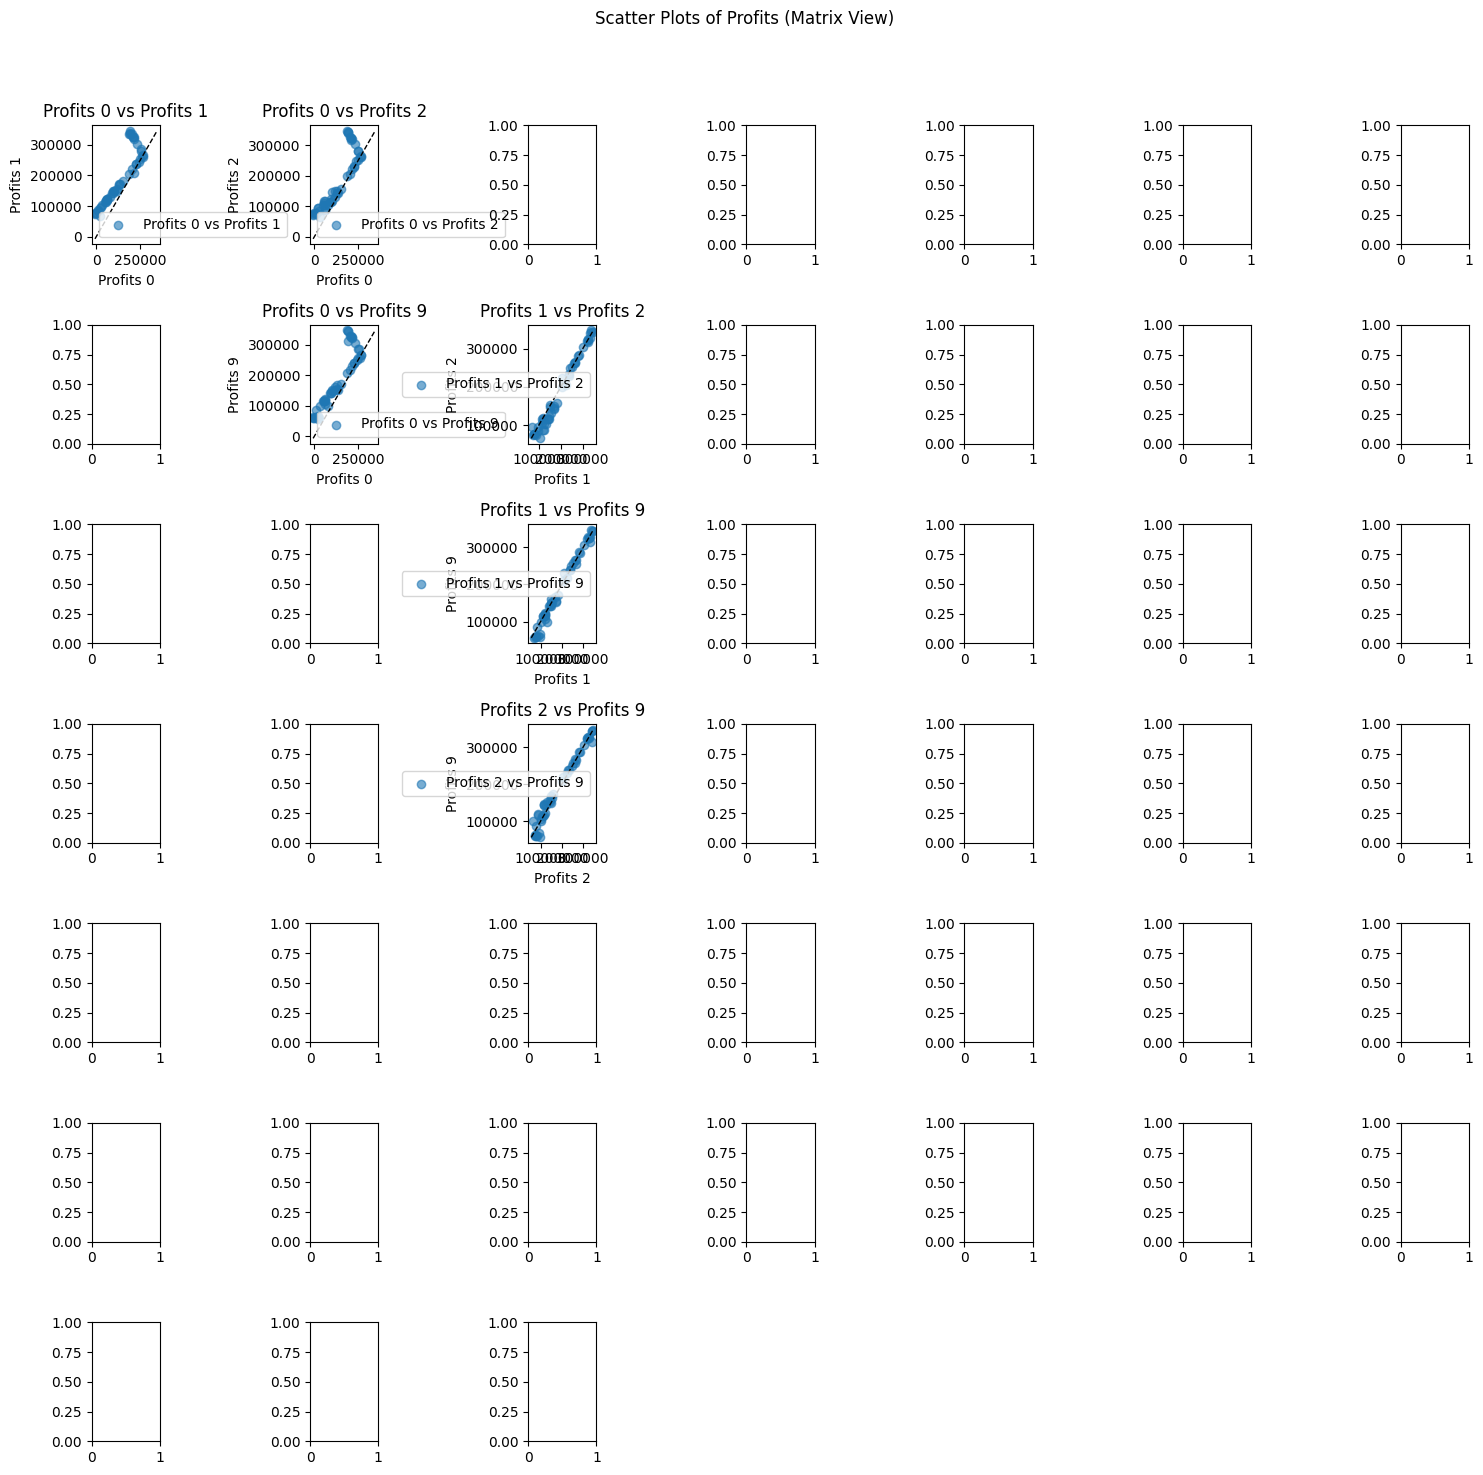

In [ ]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
    test_stimulation_results_df_10,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 135171.62040014748
S1's profit: 193453.48398424406
S2's profit: 185765.21457777265
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: -1
S9's profit: 189717.5708338967
Plot saved as plots/plot_relative_profit_deviation_test_med_with_holding_cost_20_100_202502052115.png


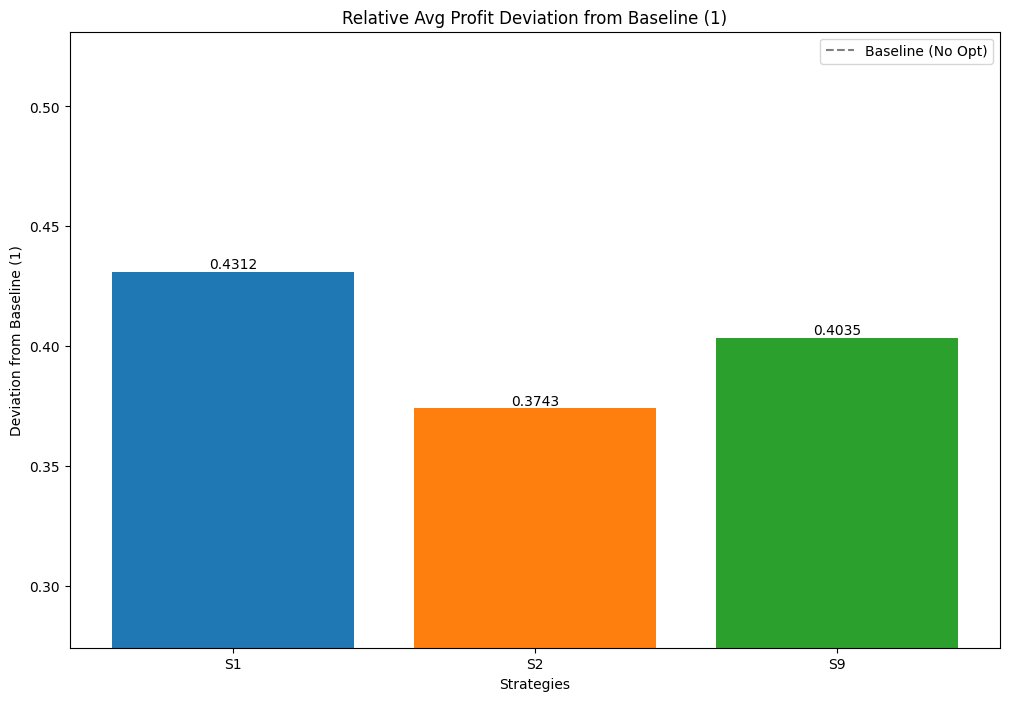

In [ ]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
    (
        test_results_df_10.iloc[0]["average_profits"]
        if test_results_df_10 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_100_S1_202502052115.png


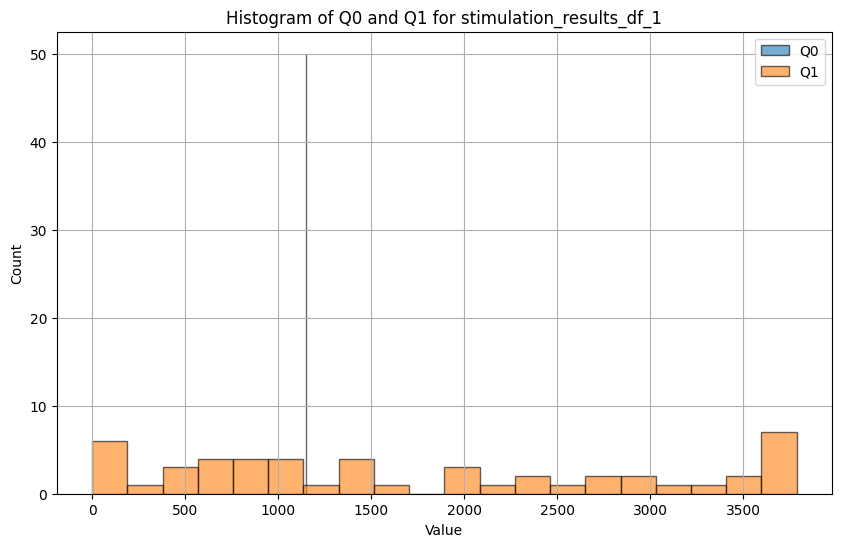

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_100_S2_202502052115.png


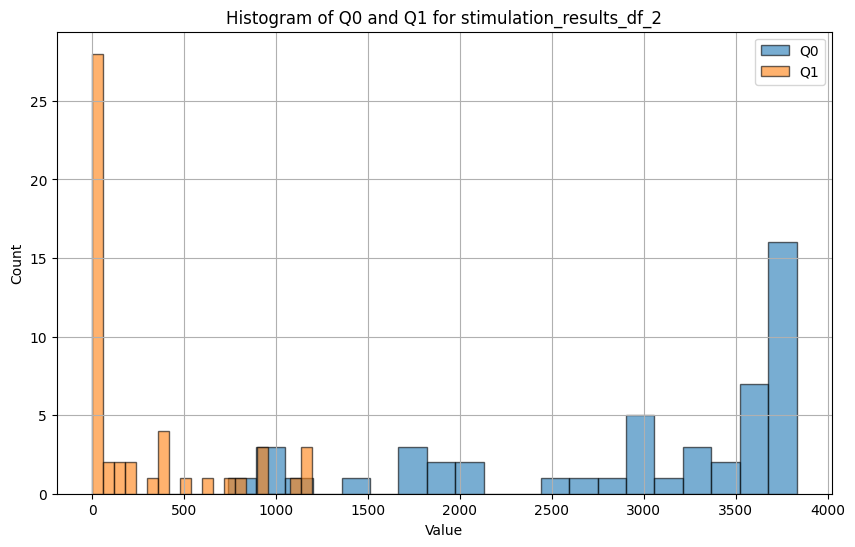

Plot saved as plots/plot_Q0_Q1_distribution_test_med_with_holding_cost_20_100_S9_202502052115.png


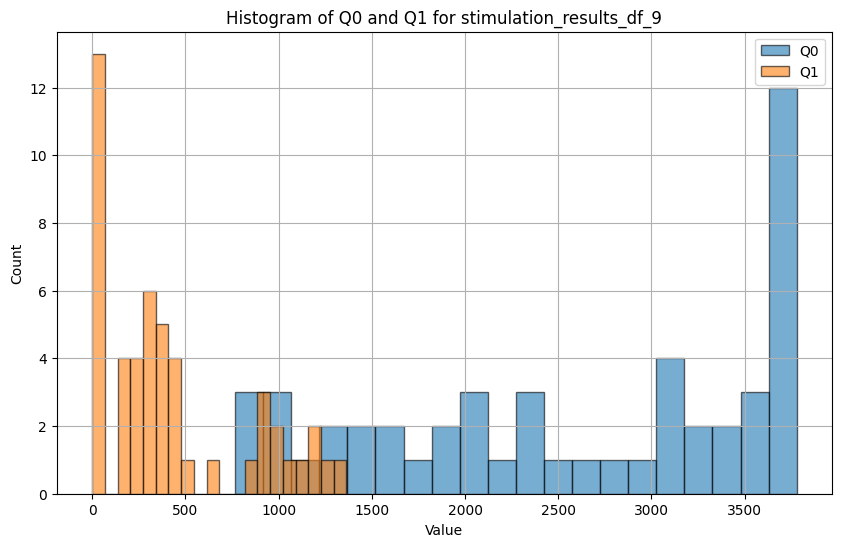

In [3594]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_100_S1_202502052115.png


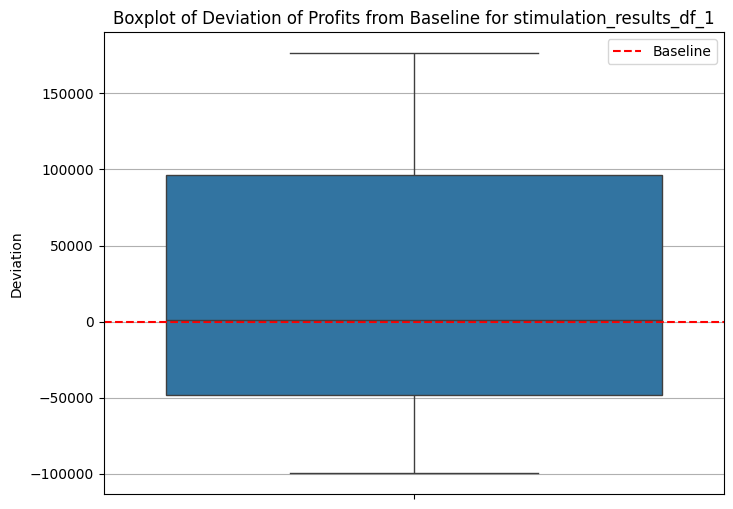

Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_100_S2_202502052115.png


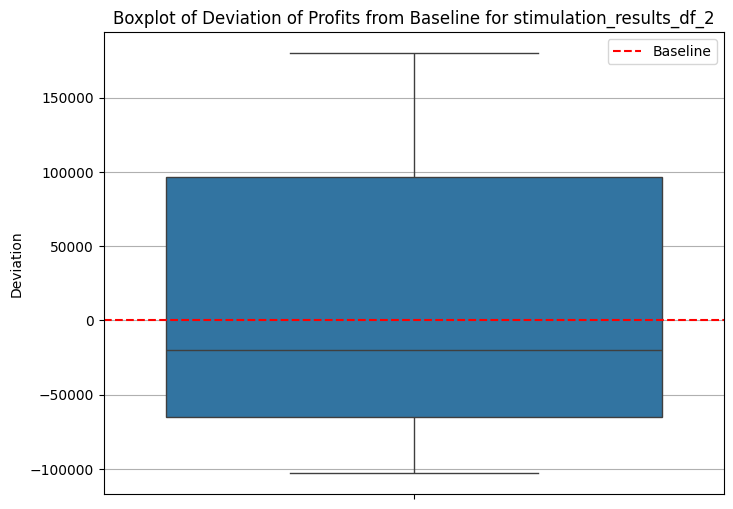

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_med_with_holding_cost_20_100_S9_202502052115.png


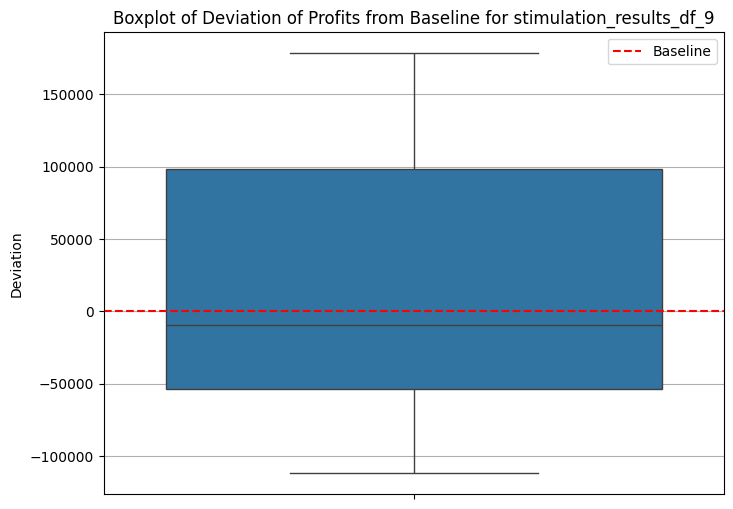

In [3595]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}", dfs[1:], baseline_avg_profits
)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_med_with_holding_cost_20_100_202502052115.png


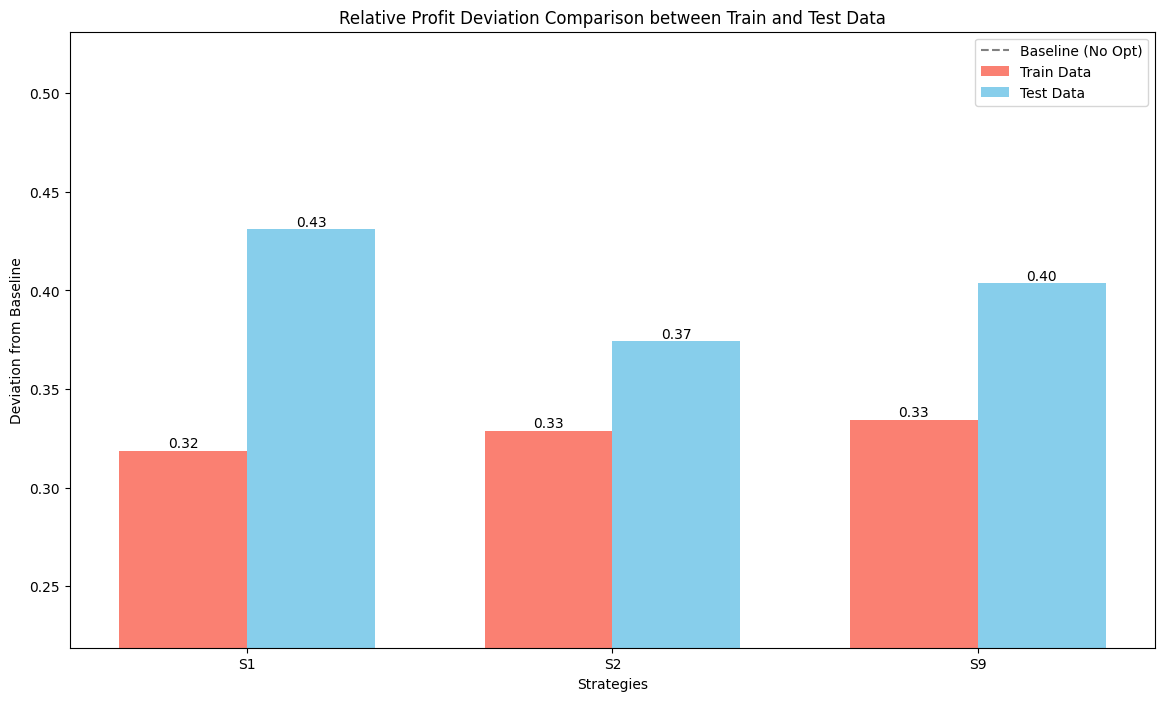

In [ ]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [3597]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]